# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load all datasets

def load_datasets(with_customers = True):
    
    print('Load started. Please wait...')
    
    azdias = pd.read_csv(filepath_or_buffer='Udacity_AZDIAS_Subset.csv', sep=';')
    print(' - AZDIAS loaded.')
    
    feat_info = pd.read_csv(filepath_or_buffer='AZDIAS_Feature_Summary.csv', sep=';')
    print(' - AZDIAS Feature Summary loaded.')
    
    dictionary  = pd.read_table('Data_Dictionary.md', skip_blank_lines=True)
    print(' - Dictionary loaded.')
    
    if with_customers:   
        customers = pd.read_csv(filepath_or_buffer='Udacity_CUSTOMERS_Subset.csv', sep=';')
        print(' - CUSTOMERS loaded.')
    else:
        customers = None
    
    print('Done.')
    
    return azdias, customers, feat_info, dictionary


def load_azdias():
    
    return pd.read_csv(filepath_or_buffer='Udacity_AZDIAS_Subset.csv', sep=';')


def load_customers():
    
    return pd.read_csv(filepath_or_buffer='Udacity_CUSTOMERS_Subset.csv', sep=';')


In [3]:
azdias, customers, feat_info, dictionary = load_datasets(False)

Load started. Please wait...
 - AZDIAS loaded.
 - AZDIAS Feature Summary loaded.
 - Dictionary loaded.
Done.


In [10]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Check dataset's shape
print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [11]:
# Take a look at first few rows (azdias)
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [12]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [13]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [14]:
# Take a look at first few rows (feat_info)
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [3]:
# Check missing values function
def check_missing_values(df, column_name, show=True):
    
    missing_list_str = feat_info[feat_info.attribute == column_name].iloc[0,3]
        
    # preparation: replace element X by 'X' (to avoid X not defined exception)
    missing_list_str = missing_list_str.replace("X", "'X'")
    missing_list_str = missing_list_str.replace("''", "") # handle XX case with empty inner quotes '' 
        
    # convert list string to list object
    missing_list = eval(missing_list_str) 

    # Performance check
    if len(missing_list) == 0:
        if show:
            print(f'Column: {column_name}\nMissing values: {missing_list}\nMissing values count: 0\n')
        return 0, missing_list
        
    # calc count
    count = len(df[df[column_name].isin(missing_list)].loc[:,column_name]) 
    if show:
        print(f'Column: {column_name}\nMissing values: {missing_list}\nMissing values count: {count}\n')
        
    return count, missing_list

In [16]:
# Check the missing values count of some columns
check_missing_values(azdias, 'AGER_TYP')
check_missing_values(azdias, 'CAMEO_DEU_2015')
check_missing_values(azdias, 'MOBI_REGIO')

Column: AGER_TYP
Missing values: [-1, 0]
Missing values count: 685843

Column: CAMEO_DEU_2015
Missing values: ['XX']
Missing values count: 373

Column: MOBI_REGIO
Missing values: []
Missing values count: 0



(0, [])

In [4]:
# Replace missing values by NaN
def handle_missing_values(df, show=False):
    
    count_total = 0
    for row in feat_info.iterrows():
        column_name = row[1][0]
        count, missing_list = check_missing_values(df, column_name, show)
        
        # replace missing values
        if count > 0:
            df.loc[df[column_name].isin(missing_list), column_name] = np.NaN  
        
        count_total += count
        
    print(f' >> Total non-null missing values count: {count_total}')

    return


In [18]:
print('Missing values replacement started. Please wait...\n')

# Total of missing values (before replacement): should be 3477091
handle_missing_values(azdias)

print('\nAnother check:\n')

# Double check: Total of missing values (after replacement): should be 0
handle_missing_values(azdias)

print('Done.')

Missing values replacement started. Please wait...

 >> Total non-null missing values count: 3477091
Another check:

 >> Total non-null missing values count: 0
Done.


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# calc the percentage of missing values and return columns that fulfill the missing values criteria
def calc_missing_values(df):
    
    # calc the missing values percentage for each column
    counts = df.isnull().sum()
    percentages = counts/len(df) * 100
    
    # select columns whose percentage of missing values is greater than 5%
    #columns = percentage[percentage > 5]
    
    df = pd.DataFrame(
        {
            'column': counts.index, 
            'missing_count': counts.values,
            'missing_percentage': percentages.values,
        })

    return df[df.missing_count > 0]

In [20]:
missing_columns = calc_missing_values(azdias)
missing_columns.sort_values(by='missing_percentage', ascending=False)

,column,missing_count,missing_percentage
40,TITEL_KZ,889061,99.757636
0,AGER_TYP,685843,76.955435
47,KK_KUNDENTYP,584612,65.596749
64,KBA05_BAUMAX,476524,53.468668
11,GEBURTSJAHR,392318,44.020282
43,ALTER_HH,310267,34.813699
70,KKK,158064,17.735668
73,REGIOTYP,158064,17.735668
48,W_KEIT_KIND_HH,147988,16.605084
62,KBA05_ANTG3,133324,14.959701


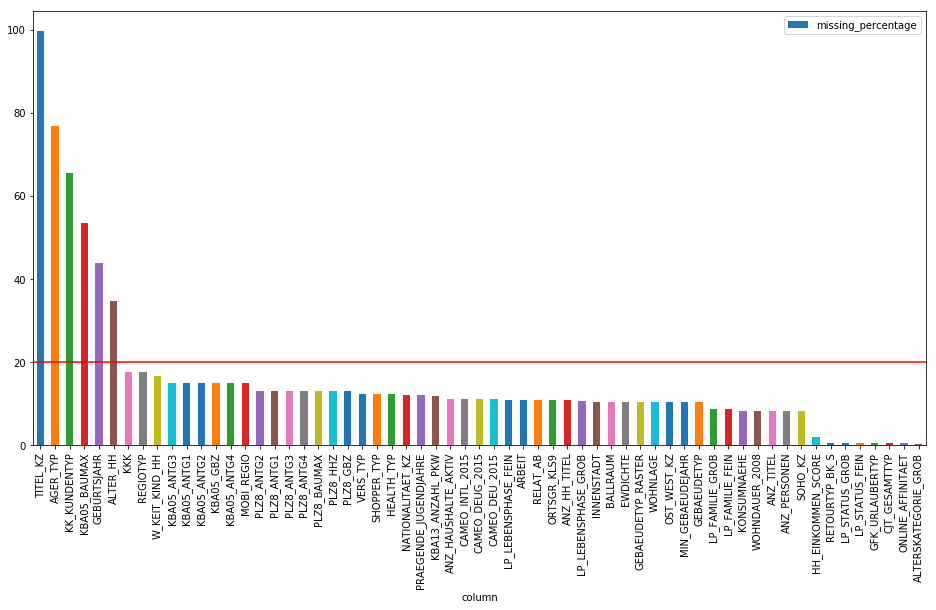

In [21]:
# Graph-1: show columns ordered by the percentage of missing values
missing_columns.sort_values(by='missing_percentage', ascending=False) \
    .plot(
        x ='column', 
        y='missing_percentage', 
        kind='bar', 
        figsize=(16,8)).axhline(y=20, color='red')

In [11]:
# Investigate patterns in the amount of missing data in each column.

We can see that there are groups of columns with the same percentage of missing values. Are this columns somehow related in to each other in terms of the missing values? Let's explore a little bit more.

We'll closely examine the columns:
- MOBI_REGIO
- KBA05_ANTG1
- KBA05_ANTG2
- KBA05_ANTG3
- KBA05_ANTG4
- KBA05_GBZ

that share the same percentage of missing values (14.959701). We want to find out if the missing values appear together all in the same row. Are this columns correlated - at least in terms of the missing values? 

In [22]:
missing_sample = azdias[['KBA05_ANTG4', 'MOBI_REGIO', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_GBZ']]

print('Sample correlated columns:')
print('-----------------------------------------') 

for column in missing_sample.columns:
    print(column)
   
print('-----------------------------------------') 

# use entire sub-dataset
total_missing_values_count = missing_sample.isnull().sum().sum()
print(f'Total missing values count: {total_missing_values_count}')

# set 0 to the missing value, 1 to non-missing value
missing_sample_2 = (missing_sample.notnull()).astype('int')

# count missing rows - rows where all values are missing
total_missing_rows_count = len(missing_sample_2[missing_sample_2.sum(axis=1) == 0]) \
    * 6 # multiply by 6 to get the total number of missing values

print(f'Total missing rows count: {total_missing_rows_count}')

Sample correlated columns:
-----------------------------------------
KBA05_ANTG4
MOBI_REGIO
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_GBZ
-----------------------------------------
Total missing values count: 799944
Total missing rows count: 799944


It looks like that they are correlated.
Now let's create the code to check all correlated columns in the dataset.

In [6]:
# Find candidate groups of columns whose missing values seems to be correlated
# which means that if there is a missing value of a certain correlated column,
# then ALL CORRELATED COLUMNS might have the missing value in the same row.
# The candidate group includes columns that have the same number of missing values.
def get_missing_groups(missing_columns):
    
    percentages = missing_columns.missing_percentage.unique()
    missing_groups = []
    
    for percentage in percentages:
        columns = missing_columns[missing_columns.missing_percentage == percentage]
        duplicates_count = columns.shape[0]

        if duplicates_count > 1:         
            missing_groups.append(columns)
           
    return missing_groups


In [7]:
# Checks if the candidate group includes correlated columns.
# Returns true if the candidate group is de facto a "missing group".
def check_missing_group(group):
    
    # 1. count missing values total for the given group  
    count = 0
    for column in group.iterrows():
        column_name = column[1][0]
        count += column[1][1]
          
    # normalize values of the group columns:
    #   - set non-missing values to 1
    #   - set missing values to 0          
    source = azdias[list(group.column)]
    normalized = (source.notnull()).astype('int')      
    normalized_count = len(normalized[normalized.sum(axis=1) == 0]) \
        * group.shape[0]    # multiply by group count to get the total number
                                # of normalized missing values
        
    # compare counts
    return count == normalized_count


In [25]:
# Iterate through missing groups

groups = get_missing_groups(missing_columns)
i = 1
for group in groups:
    
    if check_missing_group(group) == True:   
        print('---------------------')
        print(f' Group #{i}')
        print('---------------------')
        for column in group.iterrows():
            print(column[1][0]) 
        i+=1 

---------------------
 Group #1
---------------------
CJT_GESAMTTYP
GFK_URLAUBERTYP
LP_STATUS_FEIN
LP_STATUS_GROB
RETOURTYP_BK_S
ONLINE_AFFINITAET
---------------------
 Group #2
---------------------
HEALTH_TYP
SHOPPER_TYP
VERS_TYP
---------------------
 Group #3
---------------------
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
---------------------
 Group #4
---------------------
SOHO_KZ
ANZ_PERSONEN
ANZ_TITEL
WOHNDAUER_2008
---------------------
 Group #5
---------------------
GEBAEUDETYP
MIN_GEBAEUDEJAHR
OST_WEST_KZ
WOHNLAGE
---------------------
 Group #6
---------------------
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015
---------------------
 Group #7
---------------------
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_GBZ
MOBI_REGIO
---------------------
 Group #8
---------------------
BALLRAUM
EWDICHTE
INNENSTADT
---------------------
 Group #9
---------------------
KKK
REGIOTYP
---------------------
 Group #10
---------------------
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8

We have successfully isolated 11 groups with correlated columns. Note that in any of these groups all its columns have missing value in the same row.

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

In the graph-1 above there are 6 columns whose missing percentage is greater than 30% and whose distribution differs from the rest of the columns. While the rest of the columns share very similar percentage of missing values and some of them share the same percentage (correlated columns of missing groups), the outlier columns have high and isolated percentage of missing values not shared with other columns. Therefore we may conclude that these columns are good candidates for removal. As they have a high percentage of missing values and they are not correlated to other columns (in terms of missing values) it is very likely that their removal will not affect other columns and will not distort our data.

In [8]:
# Get outlier columns that are to be removed from the dataset

# Note: we'll use the GLOBAL variable g_outliers that will be used also for removing the outliers in the customer dataset.
g_outliers = []

def get_outliers(missing_columns, threshold):
    
    global g_outliers
    
    if len(g_outliers) > 0:
        return g_outliers
    
    g_outliers = missing_columns[missing_columns['missing_percentage'] > threshold]
    
    return g_outliers


In [27]:
# show outliers (thresh0ld=30)

outliers = get_outliers(missing_columns, 30)
outliers.sort_values(by='missing_percentage', ascending=False)

,column,missing_count,missing_percentage
40,TITEL_KZ,889061,99.757636
0,AGER_TYP,685843,76.955435
47,KK_KUNDENTYP,584612,65.596749
64,KBA05_BAUMAX,476524,53.468668
11,GEBURTSJAHR,392318,44.020282
43,ALTER_HH,310267,34.813699


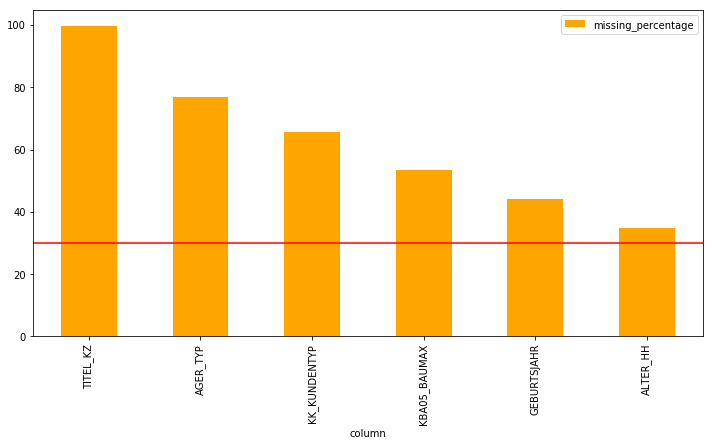

In [28]:
# Graph-2: Outliers

# Plot outliers
# The threshold line (in red) marks a value of 30%.
missing_columns[missing_columns['missing_percentage'] > 30].sort_values(by='missing_percentage', ascending=False) \
    .plot(
        x ='column', 
        y='missing_percentage', 
        kind='bar', 
        color='orange',
        figsize=(12,6)).axhline(y=30, color='red')

In [9]:
# Remove outliers
def drop_outliers(df, outliers):
    
    df2 = df.drop(outliers.column, inplace=False, axis=1)
    print(' >> Outlier columns dropped.')
    
    return df2


In [30]:
azdias = drop_outliers(azdias, outliers)
print(azdias.shape)
azdias.sample(5)

 >> Outlier columns dropped.
(891221, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
64154,3.0,2,4.0,4,2,3,2,3,1,6,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,4.0,8.0,3.0
162145,3.0,1,6.0,3,3,4,2,3,2,6,...,2.0,4.0,2.0,1.0,2.0,4.0,3.0,4.0,8.0,4.0
59174,3.0,2,2.0,3,2,4,2,3,3,5,...,2.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,3.0
284124,2.0,1,4.0,2,4,1,4,3,4,1,...,1.0,3.0,3.0,2.0,4.0,3.0,1.0,4.0,7.0,3.0
423868,1.0,1,4.0,1,5,2,5,3,5,1,...,1.0,4.0,3.0,2.0,4.0,5.0,3.0,4.0,7.0,3.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

# Summary on missing data in each column

The analysis of missing values in each column shows that there are three groups of columns: 

- high percentage (>30%) of missing values in isolated columns (TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH) 
- moderate percentage between 8% and 18% 
- low percentage < 2.1%

Many columns in the second and third group are correlated sharing the same percentage of missing values.

We decided to remove the columns of the first group due to the high percentage of missing value and due to their isolated character.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?

In [10]:
# Add column with count of missing values for every row 
def add_missing_count_column(df):
    
    df['missing_count'] = df.isnull().sum(axis=1)
    

In [32]:
# Show some missing count data
add_missing_count_column(azdias)
missing_rows = azdias.missing_count
missing_rows.head(20)

0     43
1      0
2      0
3      7
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11    47
12     6
13     8
14    47
15     8
16     6
17    47
18     3
19     0
Name: missing_count, dtype: int64

In [23]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

We'll perform aggregation of missing count value over all rows of our dataset. This way we'll get groups of missing values. The group 0 will contain rows without any missing value, the group 1 will contain rows with 1 missing values, and so on. The idea is to get to the threshold that will finally help us create two subsets using aggregates that provide additional information about the nature of missing values. We will not delve into more detailed analysis but with regard to the aggregates we have seen that many rows that have the same number of missing values actually also share the same columns where the values are missing. In that case some (not all) aggregates relates not only rows with the same number of missing values but also the columns where the value are missing.

In [11]:
# Aggregates rows by missing count value
def agg_missing_rows(df):
    
    missing_rows = df.isnull().sum(axis=1)
    
    # aggregate by sum and count rows with the same agg value
    agg = np.unique(missing_rows, return_counts=True)
    agg_df = pd.DataFrame({'sum': pd.Series(agg[0]), 'count': pd.Series(agg[1])})

    # missing aggregates
    missing_agg = agg_df[agg_df['sum'] > 0]
    
    return missing_agg


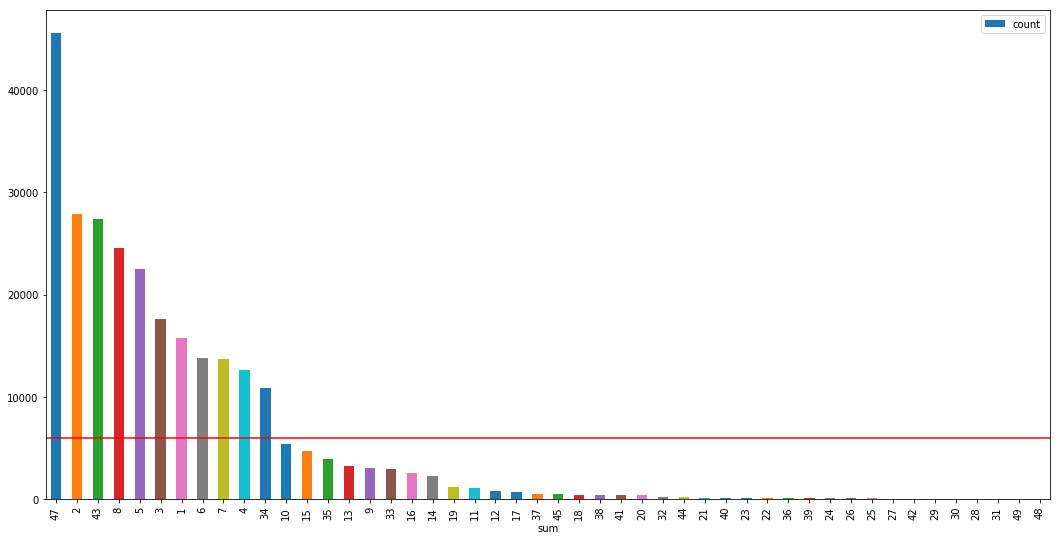

In [34]:
# Graph-3: Distribution of aggregated rows by count of missing values

missing_agg = agg_missing_rows(azdias)

# plot: order by count (descending)
# The threshold line (in red) marks a value of 6000.
missing_agg.sort_values(by='count', ascending=False) \
    .plot(
        x ='sum', 
        y='count', 
        kind='bar', 
        figsize=(18,9)).axhline(y=6000, color='red')

In [12]:
# provides missing aggregates and agg groups inside the given threshold
def get_missing_params(df, threshold):
    
    missing_agg = agg_missing_rows(df)
    return missing_agg, missing_agg[missing_agg['count'] < threshold]


# describes missing count aggregates
def describe_missing_rows(df, threshold):

    missing_agg, threshold_group = get_missing_params(df, threshold)
    
    # Threshold number of total rows for missing values applied to aggregated groups
    threshold = 6000

    all_N = missing_agg.shape[0]

    # group_N: aggregates inside the threshold
    threshold_group = missing_agg[missing_agg['count'] < threshold]
    threshold_N = threshold_group.shape[0]
    threshold_count = threshold_group.sum()[1]
    threshold_percentage = round(threshold_count / missing_rows.shape[0] * 100, 2)
    print(f'Sum of missing values row count represents {threshold_percentage}% of all rows (count={threshold_count}).')
    print('Total number of missing aggregates:', all_N)
    print('Number or candidates to remove:', threshold_N)
    print('Number of remaining missing aggregates to solve:', all_N - threshold_N)
    

In [38]:
# describe missing aggregates by threshold=6000 
describe_missing_rows(azdias, 6000)

Sum of missing values row count represents 4.01% of all rows (count=35757).
Total number of missing aggregates: 48
Number or candidates to remove: 37
Number of remaining missing aggregates to solve: 11


If we remove 37 aggregates whose rows represent 4.01% of all rows, we expect only minor impact on our data. Let's check it with the histograms.  

In [13]:
# Function that removes only rows from inside the threshold
def drop_missing_rows(df, threshold):
    
    missing_agg, threshold_group = get_missing_params(df, threshold)
    
    df2 = df[df.missing_count.isin(threshold_group['sum']) == False]
    print(' >> Missing rows dropped.')
    
    return df2


In [40]:
# Prepare dataset excluding all rows inside the threshold
azdias_rows_removal_test1 = drop_missing_rows(azdias, 6000)
azdias_rows_removal_test1.shape

 >> Missing rows dropped.


(855464, 80)

Note there are actually 79 columns because we have added one ('missing_count').

In [27]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

In [41]:
# now get list of all columns without missing values
non_missing_columns = list(azdias.columns[azdias.columns.isin(missing_columns.column) == False])
non_missing_columns.remove('missing_count') # remove 'missing_count' value
print('Non-missing columns count:', len(non_missing_columns))
print('-------------------------------')
non_missing_columns

Non-missing columns count: 24
-------------------------------


['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [14]:
# Plot: randomly choose (n) columns and compare its values between the first dataset (df1 - full rows) 
# and  the second dataset (df2 - some rows with missing vaues removed).
def plot_compare(n, df1, df2, columns=None):  
    if columns == None:
        columns = random.choices(non_missing_columns, k=n)
    for column in columns:
        plt.figure(figsize=(12,4))
        plt.subplot(121)
        ax = sns.countplot(x = column, data=df1)
        plt.title("No missing rows");
        plt.subplot(122)
        ax = sns.countplot(x = column, data=df2)
        plt.title("Missing rows");
          
    return columns


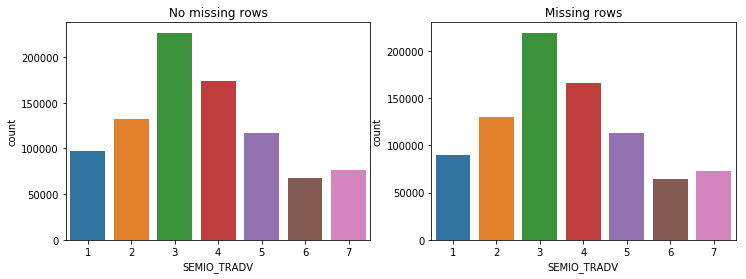

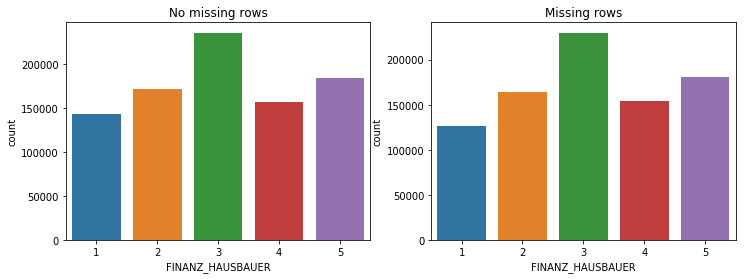

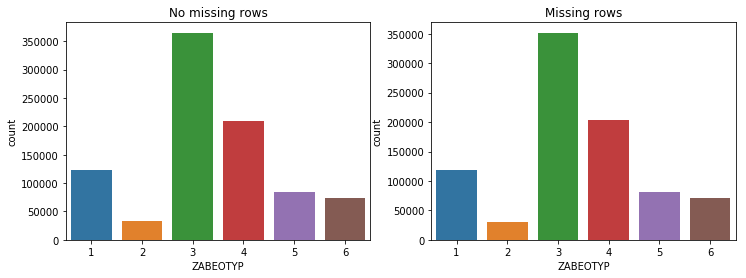

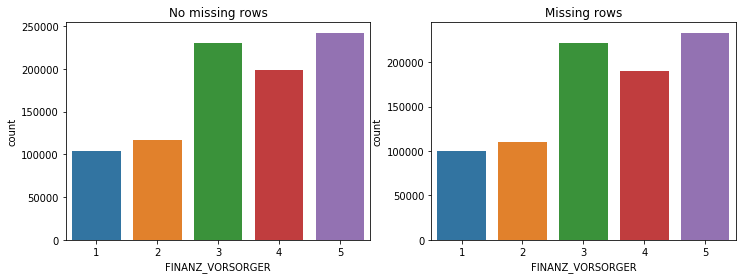

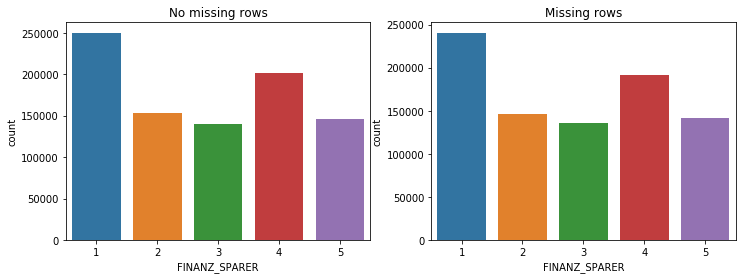

In [43]:
# Graph-4: Value distribution comparison between full and partial dataset with small row reduction, by random column 
# (5 columns without missing values)

columns = plot_compare(5, azdias, azdias_rows_removal_test1)

The graph confirms what we expected! Br removing 4% of rows inside the threshold the distribution of values almost hasn't changed. Consequently, due to the minimum impact on the value distribution we conclude that it's safe to remove the rows inside the threshold.

Let us now add one by one the rest of missing aggregates (above threshold): 47, 2, 43, 8, 5, 3, 1, 6, 7, 4, 34, ordered by the count of missing rows. Intuitively, there is less work imputing values to low aggregates (1, 3, 4, 5, 6, 7, 8) than to higher aggregates (34, 43, 47). Let's check how the value distribution changes if we remove higher aggregates, one by one: 34, 43, 47

In [44]:
# Prepare dataset based on first removal rest excluding rows of higher aggregates
azdias_rows_removal_test2 = azdias_rows_removal_test1[azdias_rows_removal_test1.missing_count.isin([34, 43, 47]) == False]
azdias_rows_removal_test2.shape

(771701, 80)

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

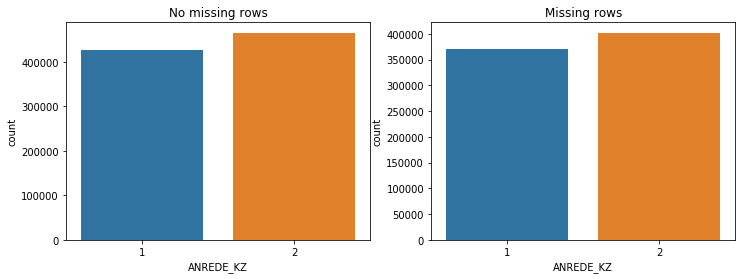

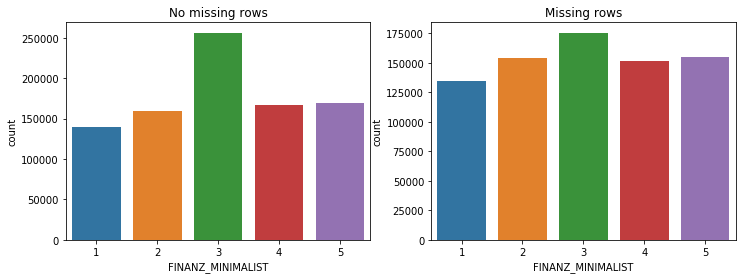

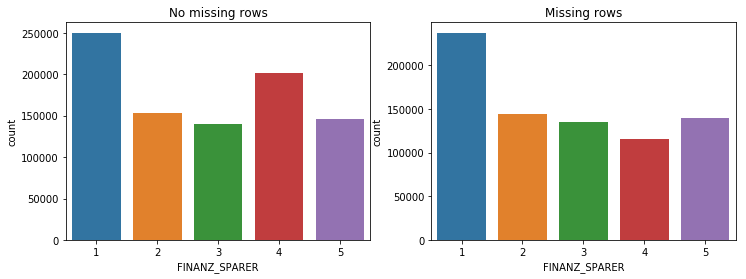

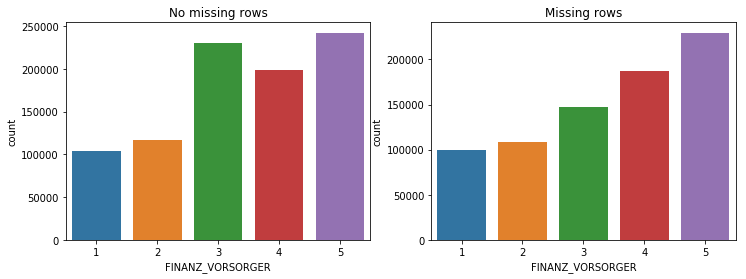

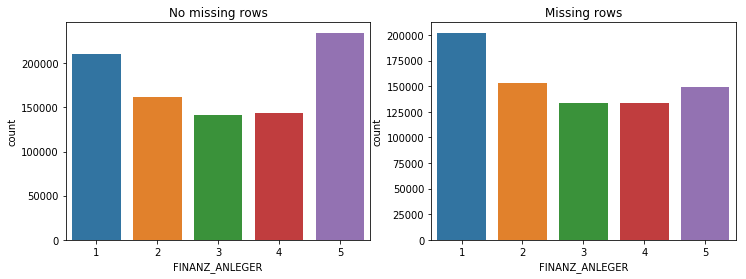

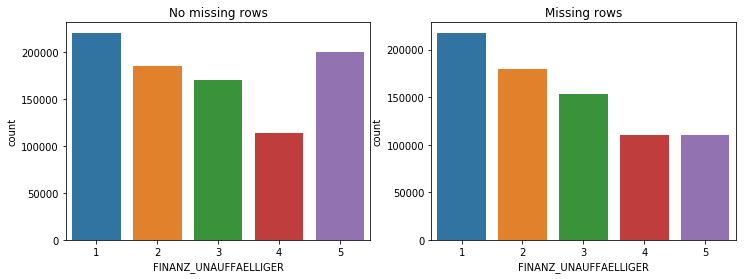

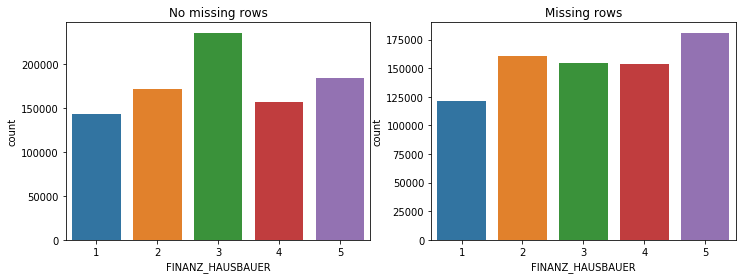

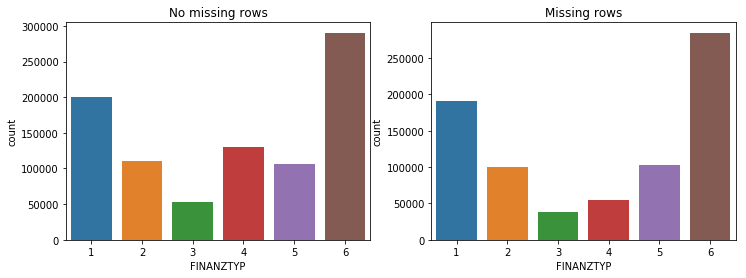

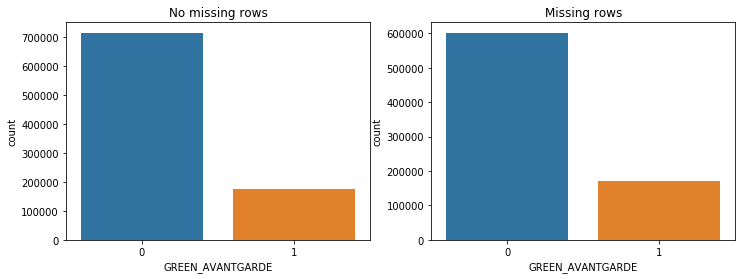

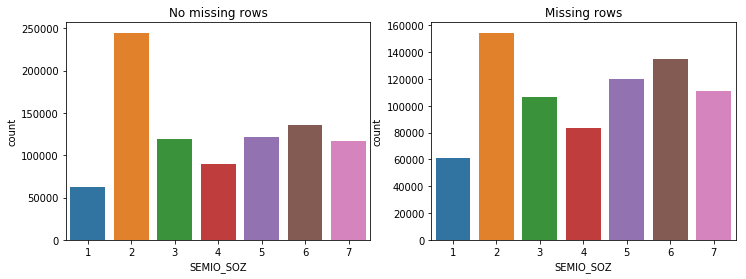

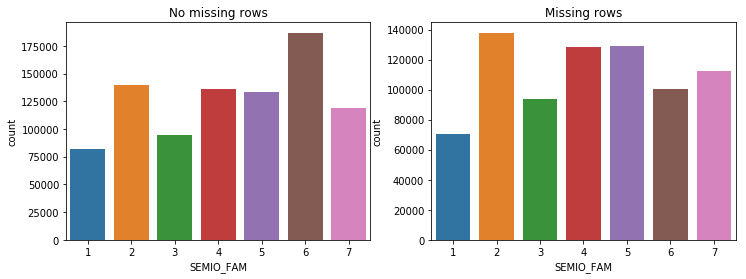

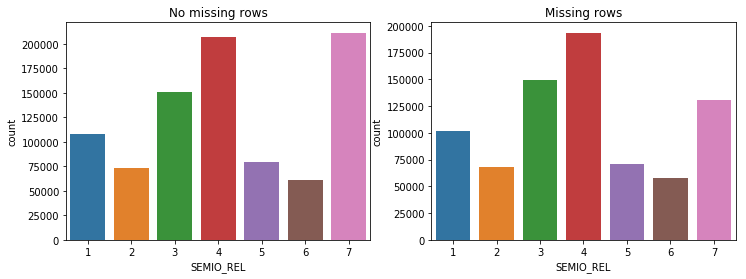

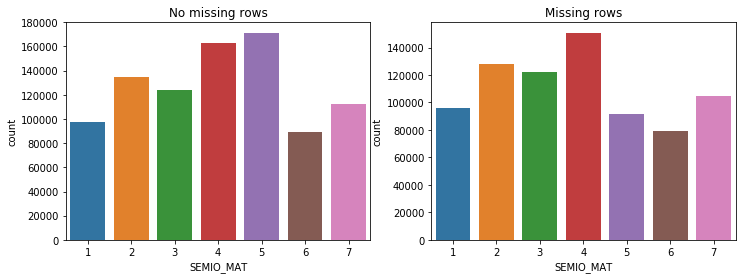

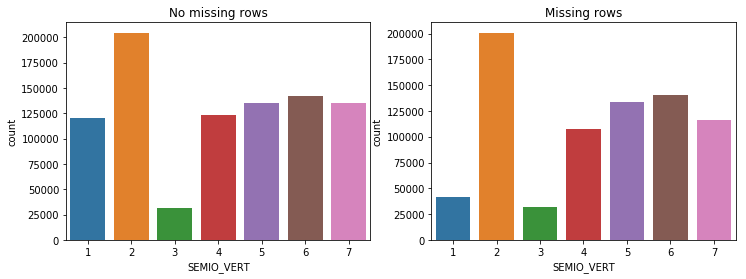

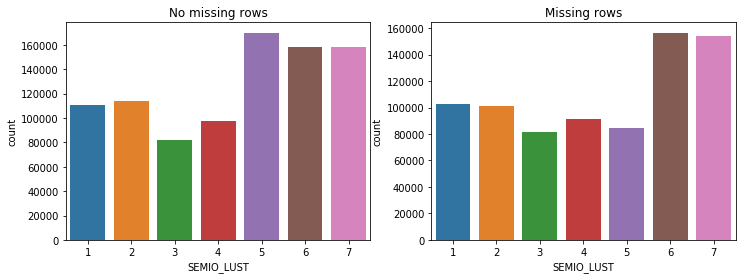

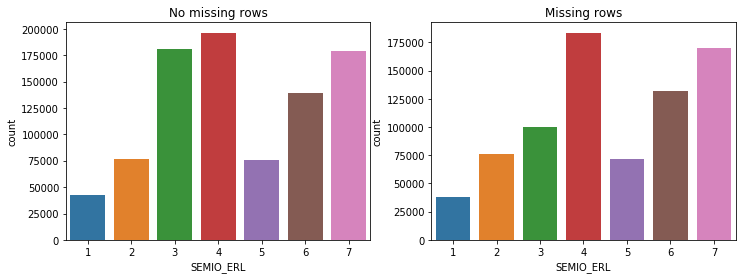

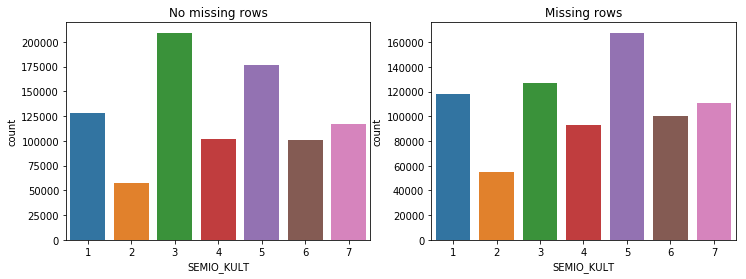

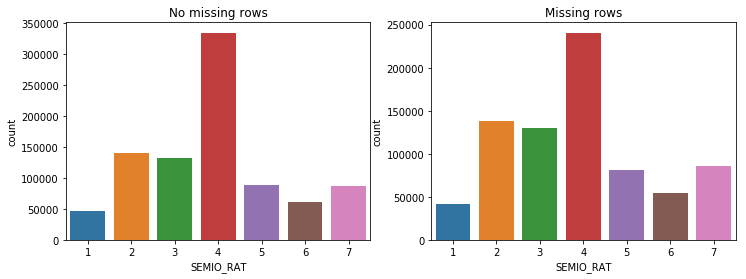

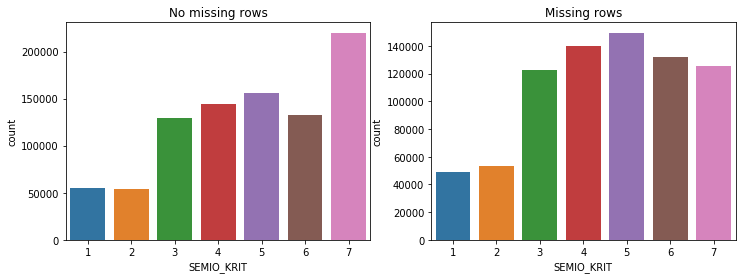

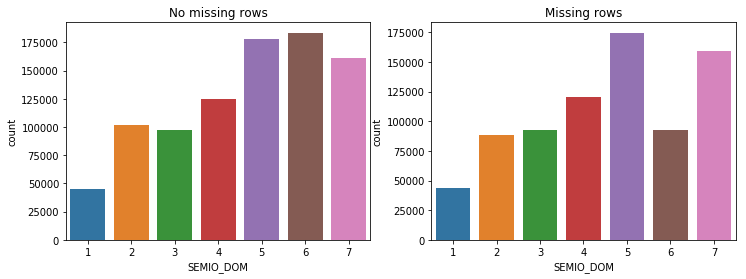

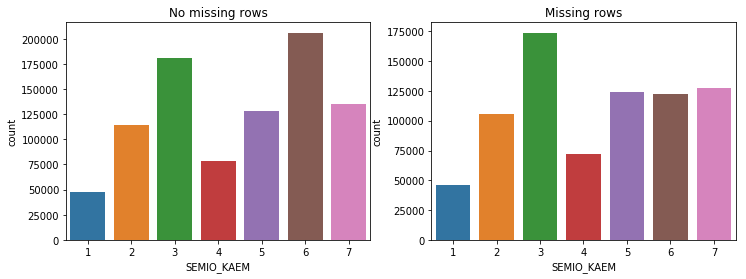

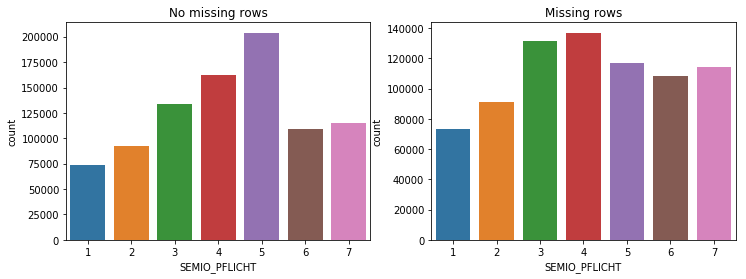

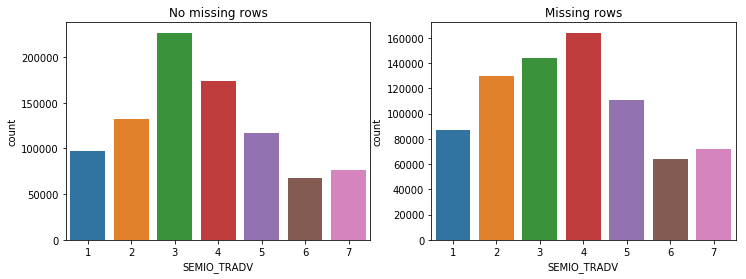

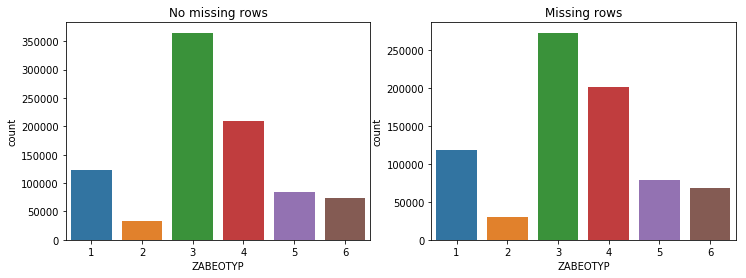

In [100]:
# Graph-5: Value distribution comparison between full and partial dataset with larger row reduction, by column 
# (all 24 columns without missing values) 

plot_compare(None, azdias, azdias_rows_removal_test2, non_missing_columns)

We can see that the value distribution almost of all columns has changed:
- FINANZ_SPARER (value 4)
- FINANZ_VORSORGER (3)
- FINANZ_ANLEGER (5)
- FINANZ_UNAUFFAELLIGER (5)
- FINANZ_HAUSBAUER (3)
- FINANZTYP (4)
- SEMIO_SOZ (2)
- SEMIO_FAM (6)
- SEMIO_REL (7)
- SEMIO_MAT (5)
- ...

Apparently, only one value in each column has changed substantially affecting the distribution graph. This makes us think that the removing of the rows above the threshold might not be the best idea. 

Consequently, we will only remove rows from inside the threshold (rows removal test1):

In [45]:
# Drop rows inside the threshold=6000
azdias = drop_missing_rows(azdias, 6000)
azdias.shape

 >> Missing rows dropped.


(855464, 80)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

# Summary on Missing Data in Each Row

We have aggregated the rows grouping them by the number of missing values in their columns. We choosed the threshold of 6000 rows per aggregated group whose total row count gave us around 4% of all rows. When we analysed the impact of removing these threshold groups from our dataset we've noticed a small impact on the value distribution of features with no missing values. Then we analysed the impact of the removal of 3 biggest groups (in terms of aggregation sum). Due to much higher impact we decided not to opt for further removing. This means that those missing values should be imputed in further steps.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [46]:
# How many features are there of each data type?

feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [40]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

In [14]:
# Get categorical features and remove outliers (previously removed from the dataset)

def get_categorical_features(df):
    
    categorical_features = feat_info.loc[feat_info['type'].isin(['categorical']), ['attribute', 'type']]
    
    return categorical_features.loc[categorical_features.attribute.isin(df.columns)]


In [48]:
categorical_features = get_categorical_features(azdias)
categorical_features.sort_values(by='attribute')

,attribute,type
2,ANREDE_KZ,categorical
57,CAMEO_DEUG_2015,categorical
58,CAMEO_DEU_2015,categorical
3,CJT_GESAMTTYP,categorical
10,FINANZTYP,categorical
52,GEBAEUDETYP,categorical
12,GFK_URLAUBERTYP,categorical
13,GREEN_AVANTGARDE,categorical
17,LP_FAMILIE_FEIN,categorical
18,LP_FAMILIE_GROB,categorical


In [15]:
# Create dataset (cdf) with necessary information about the categorical features

def prepare_cat_features(df):

    values = []
    ctypes = []
    counts = []
    
    categorical_features = get_categorical_features(df)
    for feature in list(categorical_features.attribute):
     
        unique_values = pd.unique(df.loc[df[feature].isna() == False, feature])
    
        try:
            uv = np.sort(unique_values)
        except:
            uv = unique_values
        
        values.append(uv)    
        count = unique_values.shape[0]  
        counts.append(count)
        
        # determine the type of the categorical values
        if count == 2:
            ctypes.append('binary')
        else: 
            ctypes.append('multi-level')
    
    return pd.DataFrame({
        'feature': categorical_features.attribute,
        'unique values': values,
        'count': counts,
        'type': ctypes
    })    


In [50]:
cat_features = prepare_cat_features(azdias)
cat_features.sort_values(by='type')

,feature,unique values,count,type
2,ANREDE_KZ,"[1, 2]",2,binary
55,OST_WEST_KZ,"[O, W]",2,binary
13,GREEN_AVANTGARDE,"[0, 1]",2,binary
41,VERS_TYP,"[1.0, 2.0]",2,binary
39,SOHO_KZ,"[0.0, 1.0]",2,binary
52,GEBAEUDETYP,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0]",7,multi-level
42,ZABEOTYP,"[1, 2, 3, 4, 5, 6]",6,multi-level
38,SHOPPER_TYP,"[0.0, 1.0, 2.0, 3.0]",4,multi-level
21,NATIONALITAET_KZ,"[1.0, 2.0, 3.0]",3,multi-level
20,LP_STATUS_GROB,"[1.0, 2.0, 3.0, 4.0, 5.0]",5,multi-level


We got 5 binary columns where **OST_WEST_KZ** is non-numeric. This feature needs re-encoding. Other 4 binary features remains as they are.

In [33]:
# feature OST_WEST_KZ => binary encoding

def binary_encode(df):
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    print(' >> Binary encoding done.')
    
    return


In [52]:
# binary encode
binary_encode(azdias)
azdias['OST_WEST_KZ'].sample(20)

 >> Binary encoding done.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


26497     0.0
764615    1.0
46246     0.0
873210    0.0
367321    0.0
192731    0.0
776551    0.0
41397     0.0
178330    0.0
620188    0.0
685121    1.0
539029    0.0
866631    NaN
690754    0.0
512004    0.0
801243    0.0
244286    0.0
259607    0.0
701081    0.0
639662    1.0
Name: OST_WEST_KZ, dtype: float64

In [34]:
# Re-encode categorical variable(s) to be kept in the analysis.

We have 12 categorical multi-level features with number of different values between 3 and 12. One has 44 different values: **CAMEO_DEU_2015**: 

In [53]:
data = azdias['CAMEO_DEU_2015'].value_counts()
cameo_deu_2015 = pd.DataFrame({
    'value': data.index,
    'count': data.values
}) 

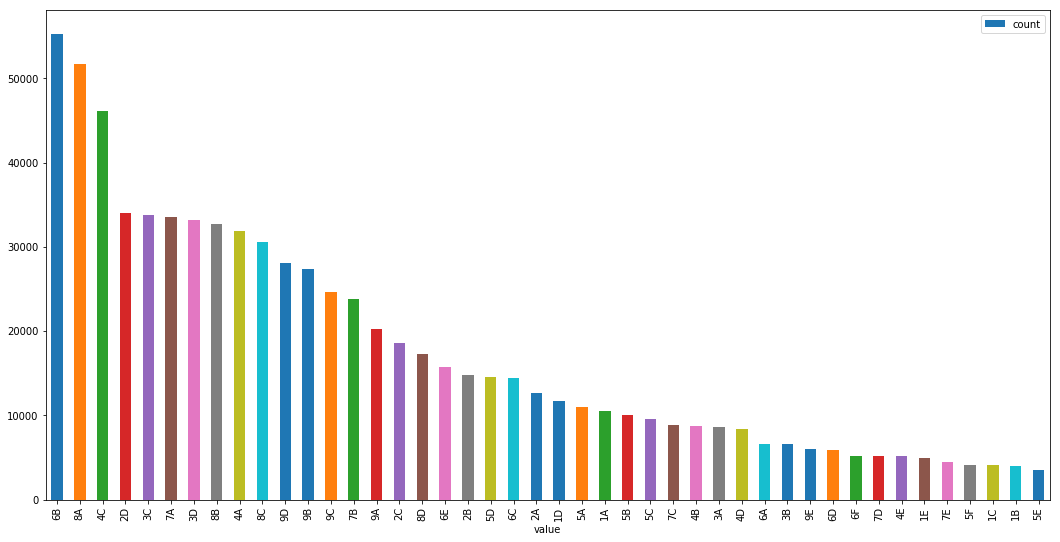

In [54]:
# Graph-6: Count distribution of 44 values of the feature CAMEO_DEU_2015 

cameo_deu_2015 \
    .plot(
        x ='value', 
        y='count', 
        kind='bar', 
        figsize=(18,9))

Let is compare the features CAMEO_DEU_2015 and CAMEO_DEUG_2015. It looks like that the latter has general information and the first one has detailed information:

In [56]:
azdias.loc[0:20, ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015']]

,CAMEO_DEU_2015,CAMEO_DEUG_2015
0,NaN,NaN
1,8A,8
2,4C,4
3,2A,2
4,6B,6
5,8C,8
6,4A,4
7,2D,2
8,1A,1
9,1E,1


In [57]:
# Check NaN values for the features in comparison:

print('CAMEO_DEU_2015 count of NaN:', azdias['CAMEO_DEU_2015'].isna().sum())
print('CAMEO_DEUG_2015 count of NaN:', azdias['CAMEO_DEUG_2015'].isna().sum())

CAMEO_DEU_2015 count of NaN: 87102
CAMEO_DEUG_2015 count of NaN: 87102


In [58]:
# Clean both columns removing NaN:
cameo_2015 = azdias.loc[azdias['CAMEO_DEU_2015'].notnull(), ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015']]
cameo_2015 = cameo_2015.loc[cameo_2015['CAMEO_DEUG_2015'].notnull()]

print('CAMEO_DEU_2015 count of NaN:', cameo_2015['CAMEO_DEU_2015'].isna().sum())
print('CAMEO_DEUG_2015 count of NaN:', cameo_2015['CAMEO_DEUG_2015'].isna().sum())

CAMEO_DEU_2015 count of NaN: 0
CAMEO_DEUG_2015 count of NaN: 0


In [59]:
# Now check if the data match:

print('Count of all rows:', len(cameo_2015))
print('Count of matched rows: ', cameo_2015[cameo_2015['CAMEO_DEU_2015'].str[0] == cameo_2015['CAMEO_DEUG_2015'].str[0]].shape[0])

Count of all rows: 768362
Count of matched rows:  768362


We have confirmed that the feature CAMEO_DEUG_2015 contains the generalized information of the feature CAMEO_DEU_2015. Since the latter has 44 categories which would increase substantially the dimensionality of our dataset, we decide not to one-hot-encode the feature CAMEO_DEU_2015 but to drop it counting with the general feature CAMEO_DEUG_2015 to carry the relevant information which we don't want to loose.

In [16]:
def drop_cameo_deu_2015(df):
    
    df2 = df.drop('CAMEO_DEU_2015', inplace=False, axis=1)
    print(' >> Feature CAMEO_DEU_2015 dropped.')
    
    return df2


In [61]:
azdias = drop_cameo_deu_2015(azdias)
azdias.shape

 >> Feature CAMEO_DEU_2015 dropped.


(855464, 79)

Honestly, it's difficult to say if the feature CAMEO_DEU_2015 play important role in our dataset or not. I will keep it and let *the dimensionality reduction algorythm (PCA) to decide.* 

None of other categorical features will be removed. We'll let the dimensionality reduction algorythm (PCA) later to do the further reduction job. Now let's one-hot-encode the rest of multi-level features:

In [17]:
# Prepare multi-level features
def get_ml_features(df):
    cat_features = prepare_cat_features(df)
    
    return cat_features[cat_features['type'] == 'multi-level'].feature


In [63]:
ml_features = get_ml_features(azdias)
ml_features

3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
42            ZABEOTYP
52         GEBAEUDETYP
57     CAMEO_DEUG_2015
Name: feature, dtype: object

In [18]:
# One-hot-encode the multi-level categorical features using dummy variables. 

def encode_ml_features(df):
    
    ml_features = get_ml_features(df)
    df2 = pd.get_dummies(df, columns=ml_features) 
    print(' >> Multi-level features encoded.')
    
    return df2


In [65]:
azdias.shape

(855464, 79)

In [66]:
azdias = encode_ml_features(azdias)
azdias.shape

 >> Multi-level features encoded.


(855464, 151)

The dimensionality of our dataset has increased from 79 to 150 (plus missing_count column).

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

# Summary on Re-Encode Categorical Features

We have examined the categorical features of our dataset and found 5 binary features and 13 multi-level features. One binary feature has been binary encoded (as instructed), the rest have been left as are. Among the multi-level features we isolated one with 44 categories (CAMEO_DEU_2015) which was contrasting the rest of the multi-level features that have between 3 and 12 categories. We made a comparison with the similar feature (CAMEO_DEUG_2015) and comfirmed that the latter contains more generalized information. As one of the very important preparation task in unsupervised learning is to reduce dimensionality, we don't want to increase it we if it is not necessary. Since one hot encoding increase the dimensionality, we decided to drop the feature CAMEO_DEU_2015 but to keep its generalized version CAMEO_DEUG_2015 (and not to loose information). All the rest multi-level features (including CAMEO_DEUG_2015) have been one hot encoded (using dummy variables).

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [67]:
# Load the dictionary file.
dictionary  = pd.read_table('Data_Dictionary.md', skip_blank_lines=True)

In [68]:
# Show info about the PRAEGENDE_JUGENDJAHRE feature
pd.set_option('display.max_colwidth', -1)
dictionary[dictionary.index.isin(range(213, 232))]

,# Data Dictionary for Identify Customer Segments Data
213,### 1.18. PRAEGENDE_JUGENDJAHRE
214,Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
215,- -1: unknown
216,- 0: unknown
217,"- 1: 40s - war years (Mainstream, E+W)"
218,"- 2: 40s - reconstruction years (Avantgarde, E+W)"
219,"- 3: 50s - economic miracle (Mainstream, E+W)"
220,"- 4: 50s - milk bar / Individualisation (Avantgarde, E+W)"
221,"- 5: 60s - economic miracle (Mainstream, E+W)"
222,"- 6: 60s - generation 68 / student protestors (Avantgarde, W)"


In [19]:
# Prepare the PRAEGENDE_JUGENDJAHRE feature:

def prepare_praegende_jugendjahre_feature():
    
    values = range(1, 16)
    decades = [40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
    new_decades = [0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5]
    movements = ['M', 'A', 'M', 'A', 'M', 'A', 'A', 'M', 'A', 'M', 'A', 'M', 'A', 'M', 'A']
    new_movements = [(0 if x == 'M' else 1) for x in movements]
    nations = ['E+W', 'E+W', 'E+W', 'E+W', 'E+W', 'W', 'E', 'E+W', 'E+W', 'W', 'W', 'E', 'E', 'E+W', 'E+W']
    
    return pd.DataFrame({
        'value': values,
        'decade': decades,
        'new_decade': new_decades,
        'movement': movements,
        'new_movement': new_movements,
        'nation': nations
    })


In [70]:
praegende_jugendjahre = prepare_praegende_jugendjahre_feature()
praegende_jugendjahre

,value,decade,new_decade,movement,new_movement,nation
0,1,40,0,M,0,E+W
1,2,40,0,A,1,E+W
2,3,50,1,M,0,E+W
3,4,50,1,A,1,E+W
4,5,60,2,M,0,E+W
5,6,60,2,A,1,W
6,7,60,2,A,1,E
7,8,70,3,M,0,E+W
8,9,70,3,A,1,E+W
9,10,80,4,M,0,W


In [20]:
# mapping function for PRAEGENDE_JUGENDJAHRE

def map_praegende_jugendjahre(df):
    
    praegende_jugendjahre = prepare_praegende_jugendjahre_feature()
    
    decade_map = dict()
    movement_map = dict()
    for row in praegende_jugendjahre.iterrows():
        decade_map[row[1][0]] = row[1][2]
        movement_map[row[1][0]] = row[1][4]
        
    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_map)    
    print(' >> Mapping of the feature PRAEGENDE_JUGENDJAHRE done.')
    
    return
    

In [72]:
# do the mapping

map_praegende_jugendjahre(azdias)
azdias.shape

 >> Mapping of the feature PRAEGENDE_JUGENDJAHRE done.


(855464, 153)

In [73]:
# check PRAEGENDE_JUGENDJAHRE_decade:

azdias.loc[:, ['PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE_decade']].sample(5)

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_decade
412719,9.0,3.0
21479,8.0,3.0
698912,5.0,2.0
101957,6.0,2.0
540759,5.0,2.0


In [75]:
# check PRAEGENDE_JUGENDJAHRE_movement:

azdias.loc[:, ['PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE_movement']].sample(5)

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_movement
448751,11.0,1.0
437536,8.0,0.0
522138,8.0,0.0
279749,9.0,1.0
159868,3.0,0.0


In [51]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

In [76]:
dictionary[dictionary.index.isin(range(491, 520))]

,# Data Dictionary for Identify Customer Segments Data
491,### 4.3. CAMEO_INTL_2015
492,"German CAMEO: Wealth / Life Stage Typology, mapped to international code"
493,- -1: unknown
494,- 11: Wealthy Households - Pre-Family Couples & Singles
495,- 12: Wealthy Households - Young Couples With Children
496,- 13: Wealthy Households - Families With School Age Children
497,- 14: Wealthy Households - Older Families & Mature Couples
498,- 15: Wealthy Households - Elders In Retirement
499,- 21: Prosperous Households - Pre-Family Couples & Singles
500,- 22: Prosperous Households - Young Couples With Children


In [21]:
# mapping functions for CAMEO_INTL_2015

def wealth_map(x):
    s = str(x)
    if s.isdigit():
        return s[0]
    else:
        return x
            
                   
def lifestage_map(x):
    s = str(x)
    if s.isdigit():
        return s[1]
    else:
        return x              
                   

def map_cameo_intl_2015(df):     
    
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(wealth_map)
    df['CAMEO_INTL_2015_lifestage'] = df['CAMEO_INTL_2015'].apply(lifestage_map)
    print(' >> Mapping of the feature CAMEO_INTL_2015 done.')
    
    return


In [78]:
# do the mapping

map_cameo_intl_2015(azdias)

 >> Mapping of the feature CAMEO_INTL_2015 done.


In [79]:
# check CAMEO_INTL_2015_wealth:

azdias.loc[:, ['CAMEO_INTL_2015', 'CAMEO_INTL_2015_wealth']].sample(5)

,CAMEO_INTL_2015,CAMEO_INTL_2015_wealth
812190,25,2
751905,54,5
26083,32,3
269801,41,4
283530,NaN,NaN


In [80]:
# check CAMEO_INTL_2015_lifestage:

azdias.loc[:, ['CAMEO_INTL_2015', 'CAMEO_INTL_2015_lifestage']].sample(5)

,CAMEO_INTL_2015,CAMEO_INTL_2015_lifestage
184143,25,5
274939,51,1
795545,14,4
707104,43,3
708352,51,1


Let's now study other mixed features.

In [81]:
# Get the rest of mixed features
mixed_features = feat_info.loc[feat_info['type'].isin(['mixed']), ['attribute', 'type']]
mixed_features = mixed_features.loc[mixed_features.attribute.isin(outliers.column) == False]
mixed_features = mixed_features.loc[mixed_features.attribute.isin(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']) == False]
mixed_features

,attribute,type
15,LP_LEBENSPHASE_FEIN,mixed
16,LP_LEBENSPHASE_GROB,mixed
56,WOHNLAGE,mixed
79,PLZ8_BAUMAX,mixed


In [82]:
np.sort(pd.unique(azdias['LP_LEBENSPHASE_FEIN']))

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  nan])

In [83]:
np.sort(pd.unique(azdias['LP_LEBENSPHASE_GROB']))

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  nan])

In [84]:
# feature LP_LEBENSPHASE_FEIN

dictionary[dictionary.index.isin(range(109, 151))]

,# Data Dictionary for Identify Customer Segments Data
109,### 1.11. LP_LEBENSPHASE_FEIN
110,"Life stage, fine scale"
111,- 1: single low-income earners of younger age
112,- 2: single low-income earners of middle age
113,- 3: single average earners of younger age
114,- 4: single average earners of middle age
115,- 5: single low-income earners of advanced age
116,- 6: single low-income earners at retirement age
117,- 7: single average earners of advanced age
118,- 8: single average earners at retirement age


In [85]:
# feature LP_LEBENSPHASE_GROB

dictionary[dictionary.index.isin(range(151, 165))]

,# Data Dictionary for Identify Customer Segments Data
151,### 1.12. LP_LEBENSPHASE_GROB
152,"Life stage, rough scale"
153,- 1: single low-income and average earners of younger age
154,- 2: single low-income and average earners of higher age
155,- 3: single high-income earners
156,- 4: single low-income and average-earner couples
157,- 5: single high-income earner couples
158,- 6: single parents
159,- 7: single low-income and average earner families
160,- 8: high-income earner families


We'll apply the same rule to the column **LP_LEBENSPHASE_FEIN** as we have to the column CAMEO_DEU_2015: as the LP_LEBENSPHASE_FEIN is a detailed information about life stage with 40 categories and the column **LP_LEBENSPHASE_GROB** offers a generalized information about the same life stage feature, we'll *remove the column LP_LEBENSPHASE_FEIN*.

In [86]:
# feature WOHNLAGE

dictionary[dictionary.index.isin(range(418, 429))]

,# Data Dictionary for Identify Customer Segments Data
418,### 3.7. WOHNLAGE
419,Neighborhood quality (or rural flag)
420,- -1: unknown
421,- 0: no score calculated
422,- 1: very good neighborhood
423,- 2: good neighborhood
424,- 3: average neighborhood
425,- 4: poor neighborhood
426,- 5: very poor neighborhood
427,- 7: rural neighborhood


In [87]:
# feature PLZ8_BAUMAX

dictionary[dictionary.index.isin(range(678, 687))]

,# Data Dictionary for Identify Customer Segments Data
678,### 8.6. PLZ8_BAUMAX
679,Most common building type within the PLZ8 region
680,- -1: unknown
681,- 0: unknown
682,- 1: mainly 1-2 family homes
683,- 2: mainly 3-5 family homes
684,- 3: mainly 6-10 family homes
685,- 4: mainly 10+ family homes
686,- 5: mainly business buildings


The other two features does not seem to contain too many categories. It is very likely that the feature PLZ8_BAUMAX contains dependent information being contained already in some of the RR3 micro-cell features, but we opt to leave the dimension reduction algorithm to decide which features are independent and which are not. 

So let's apply the same one hot encoding (dummy) over the following mixed-type features:
- LP_LEBENSPHASE_GROB
- WOHNLAGE
- PLZ8_BAUMAX

And we'll drop the following mixed-type features:
- PRAEGENDE_JUGENDJAHRE (replaced by PRAEGENDE_JUGENDJAHRE_decade and PRAEGENDE_JUGENDJAHRE_movement)
- CAMEO_INTL_2015 (replaced by CAMEO_INTL_2015_wealth and CAMEO_INTL_2015_lifestage) 
- LP_LEBENSPHASE_FEIN (generalized by LP_LEBENSPHASE_GROB)

In [22]:
# One hot encoding of mixed-type feature

def encode_mixed_features(df):
    
    df2 = pd.get_dummies(df, columns=['LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX'])
    print(' >> Mixed features encoded.')
    
    return df2


In [89]:
azdias = encode_mixed_features(azdias)
azdias.shape

 >> Mixed features encoded.


(855464, 177)

In [23]:
# Features to drop

def drop_mixed_features(df):
    
    df2 = df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN'], inplace=False, axis=1)
    print(' >> Mixed features dropped.')
    
    return df2


In [91]:
azdias = drop_mixed_features(azdias)
azdias.shape

 >> Mixed features dropped.


(855464, 174)

## Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

# Summary on Engineer Mixed-Type Features

We have expanded the information over two features, PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, mapping each other into two features. Both original features were later removed. The other feature LP_LEBENSPHASE_FEIN was also removed due to being to detailed and already contained in more generalized feature LP_LEBENSPHASE_GROB. The rest of mixed-type features have been retained and one hot encoded.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [98]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

In [92]:
values = []
for column in azdias.columns:
    values.append(pd.unique(azdias[column]))

coldf = pd.DataFrame({
    'column': azdias.columns,
    'values': values
})

coldf

,column,values
0,ALTERSKATEGORIE_GROB,"[2.0, 1.0, 3.0, 4.0, nan]"
1,ANREDE_KZ,"[1, 2]"
2,FINANZ_MINIMALIST,"[3, 1, 4, 2, 5]"
3,FINANZ_SPARER,"[4, 5, 2, 3, 1]"
4,FINANZ_VORSORGER,"[3, 2, 1, 5, 4]"
5,FINANZ_ANLEGER,"[5, 2, 1, 4, 3]"
6,FINANZ_UNAUFFAELLIGER,"[5, 4, 3, 1, 2]"
7,FINANZ_HAUSBAUER,"[3, 5, 2, 4, 1]"
8,GREEN_AVANTGARDE,"[0, 1]"
9,HEALTH_TYP,"[nan, 3.0, 2.0, 1.0]"


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [24]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    print('Cleaning started. Please wait...')
    print('===========================================================')
    print('Input shape:', df.shape)
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    print('\n > Handling missing values...')
    handle_missing_values(df) 
    
    # remove selected columns ...
    print(' > Removing columns...')
    missing_columns = calc_missing_values(df)
    outliers = get_outliers(missing_columns, 30)
    df = drop_outliers(df, outliers)
    add_missing_count_column(df)
    
    # select, re-encode, and engineer column values.
    print(' > Selecting, re-encoding, engineering column values...')
    binary_encode(df)
    df = drop_cameo_deu_2015(df) 
    df = encode_ml_features(df)
    map_praegende_jugendjahre(df)
    map_cameo_intl_2015(df)
    df = encode_mixed_features(df)
    df = drop_mixed_features(df)
    
    # remove missing rows
    print(' > Removing rows...')
    df = drop_missing_rows(df, 6000)
    
    print('\nOutput shape:', df.shape)
    print('===========================================================')
    print('Cleaning done.')    
    
    # Return clean dataframe.
    return df


In [39]:
# Load again all datasets
azdias, customers, feat_info, dictionary = load_datasets()

Load started. Please wait...
 - AZDIAS loaded.
 - AZDIAS Feature Summary loaded.
 - Dictionary loaded.
 - CUSTOMERS loaded.
Done.


In [40]:
# Clean our dataset

azdias = clean_data(azdias)

Cleaning started. Please wait...
Input shape: (891221, 85)

 > Handling missing values...
 >> Total non-null missing values count: 3477091
 > Removing columns and rows...
 >> Outlier columns dropped.
 > Selecting, re-encoding, engineering column values...
 >> Binary encoding done.
 >> Feature CAMEO_DEU_2015 dropped.
 >> Multi-level features encoded.
 >> Mapping of the feature PRAEGENDE_JUGENDJAHRE done.
 >> Mapping of the feature CAMEO_INTL_2015 done.
 >> Mixed features encoded.
 >> Mixed features dropped.
 >> Missing rows dropped.

Output shape: (833280, 174)
Cleaning done.


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

We decided not to remove ALL rows that contain missing values. The reason was that the column comparison test showed that the value distribution of some categories would change when selecting rows above the threshold. We removed only the rows inside the chosen threshold since the column comparison didn't show any drastical change in value distribution for these rows. 

We opt to impute the missing values that remained. Let's do it.

In [39]:
# Count all missing values in a given dataframe

def count_all_missing_values(df):
    
    return df.isnull().sum().sum()


In [36]:
# impute missing values for the given dataframe

def impute_missing_values(df, imputer=None):
    
    print('Imputing started. Please wait...')
    print(' >> Missing values count (before):', count_all_missing_values(df))
    
    if imputer == None:
        imputer = Imputer(missing_values=np.nan, strategy='mean')
    
    imputed = imputer.fit_transform(df)
    df2 = pd.DataFrame(imputed, columns=df.columns)
    
    # remove missing_count column
    if 'missing_count' in df2.columns:
        df2.drop('missing_count', inplace=True, axis=1)
    
    print(' >> Missing values count (after):', count_all_missing_values(df2))
    print('Imputing done.')
    
    return df2, imputer
    

In [47]:
# do impute
# Note that we'll use the imputer object later when imputing the customers data. 

azdias, imputer = impute_missing_values(azdias)

Imputing started. Please wait...
 >> Missing values count (before): 3274631
 >> Missing values count (after): 0
Imputing done.


In [37]:
# Apply feature scaling to the general population demographics data.

def apply_feature_scaling(df, scaler=None):
    
    print('Feature scaling started. Please wait...')
    
    if scaler == None:
        scaler = StandardScaler()
    
    X = scaler.fit_transform(df)
    print('Feature scaling done.')
    
    return X, scaler


In [49]:
# do apply feature scaling
# Note that we'll use the scaler object later when scaling the customers data. 

X, scaler = apply_feature_scaling(azdias)
X

Feature scaling started. Please wait...
Feature scaling done.


array([[-0.74313724, -1.04111679, -0.04093625, ..., -0.25176331,
        -0.26690024, -0.35833274],
       [-1.73127999,  0.96050704, -1.5686413 , ..., -0.25176331,
        -0.26690024, -0.35833274],
       [ 0.24500551,  0.96050704, -1.5686413 , ..., -0.25176331,
        -0.26690024, -0.35833274],
       ..., 
       [-0.74313724,  0.96050704, -0.80478878, ..., -0.25176331,
        -0.26690024, -0.35833274],
       [-1.73127999, -1.04111679, -1.5686413 , ..., -0.25176331,
        -0.26690024,  2.79070231],
       [ 1.23314825, -1.04111679,  0.72291627, ..., -0.25176331,
        -0.26690024, -0.35833274]])

In [ ]:
pd.DataFrame(X).to_csv('azdias_scaled_checkpoint_1.csv', sep=';')

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

# Summary on Feature Scaling

We have replaced missing values by mean values using sklearn's Imputer class and then we have applied feature scaling using sklearn's StandardScaler class. Now our dataset is without missing values, i's values are properly scaled and it is ready to apply dimensionality reduction. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [46]:
def do_pca(X, n_components=None):
    
    print('PCA started. Please wait...')
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)   
    print('PCA done.')
    
    return pca, X_pca


In [51]:
# do PCA with all components

pca, X_pca = do_pca(X)

PCA started. Please wait...
PCA done.


In [47]:
# We'll use the function scree_plot from the Udacity helper class
# to visualize the variance retained by the principal components

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=9)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

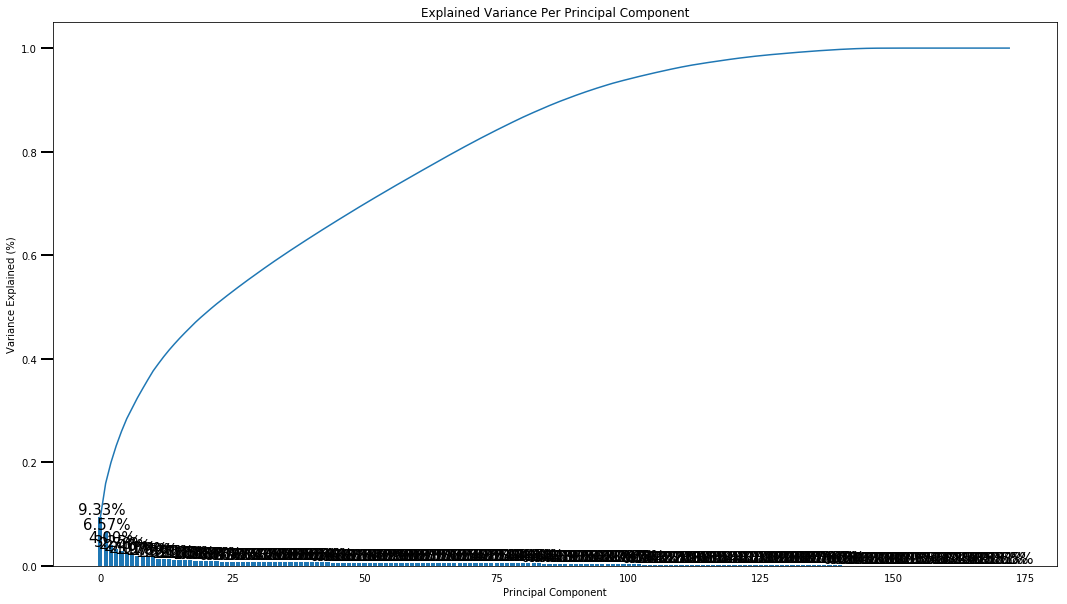

In [53]:
# Graph-7: Explained Variance Per Principal Component (no component number definition) 

scree_plot(pca)

In [54]:
# gets the number of components needed for the given variability value

def get_n_components(pca, variability):
    
    return min(np.where(np.cumsum(pca.explained_variance_ratio_) > variability)[0] + 1)


In [55]:
# Find n_components for 60% of variability (=sum of variance explained) covered by the principal components

n_components = get_n_components(pca, 0.6)
n_components

36

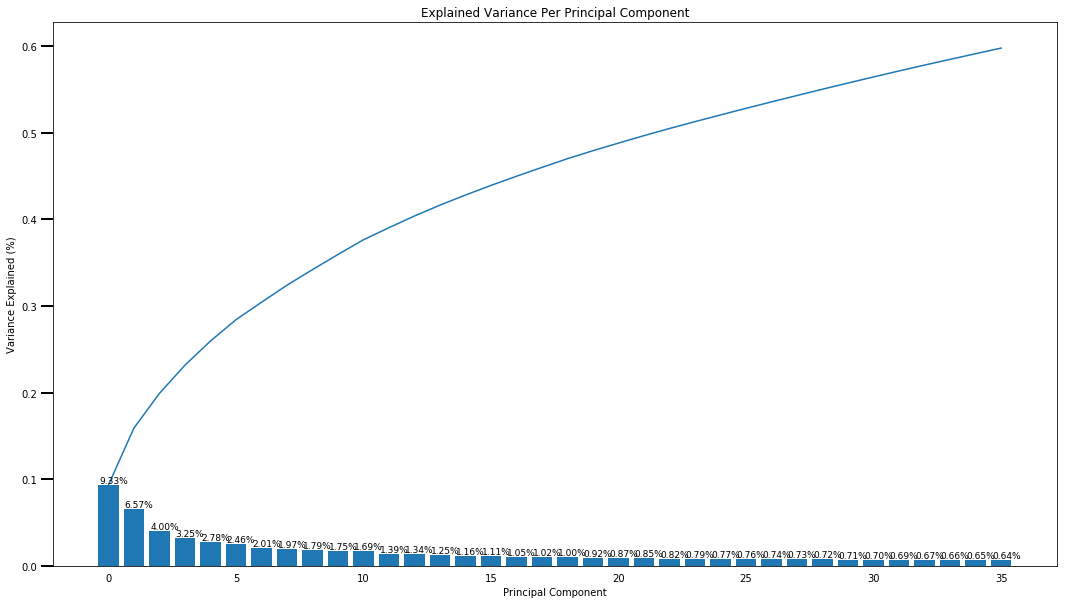

In [60]:
# Graph-8: Explained Variance Per Principal Component (36 components) 

pca, X_pca = do_pca(X, 36)
scree_plot(pca)

In [61]:
# Check the sum of variance explained (with 36 components)

pca.explained_variance_ratio_.sum()

0.59791783542191734

In [64]:
# Save checkpoints

azdias.to_csv('azdias_checkpoint_1.csv', sep=';')
pd.DataFrame(X_pca).to_csv('azdias_X_pca_checkpoint_1.csv', sep=';')

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

# Summary on Dimensionality Reduction

Having applied PCA to reduce dimensionality of 173 features of our dataset after the cleaning was performed we have achieved 60% of the cumulative explained variance using 36 components.  

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

In [51]:
# Creates dataframe with principal components and feature weights
# (The function is based on the Udacity function pca_results from the helper class.)

def get_pca_components(pca, df):
    
    # Dimension indexing
    dimensions = dimensions = ['Principal Component {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns=df.columns)
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Add variance_ratios to the components DataFrame
    components = pd.concat([variance_ratios, components], axis = 1)
    
    return components


In [66]:
# Show principal components dataframe
get_pca_components(pca, azdias)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
Principal Component 1,0.0933,-0.0735,0.0135,-0.1828,0.1026,-0.0751,0.0438,0.0443,0.1466,-0.0981,...,0.0316,0.0670,0.0536,-0.1079,-0.0363,-0.1687,0.0381,0.0603,0.0794,0.1104
Principal Component 2,0.0658,0.2277,0.0140,0.1009,-0.2352,0.2229,-0.2145,-0.2168,0.0752,0.0093,...,0.0309,0.0226,0.0124,-0.0288,-0.0232,-0.0320,0.0228,0.0270,0.0304,0.0385
Principal Component 3,0.0401,-0.0147,-0.2981,0.0931,-0.0384,0.0085,-0.1467,-0.0764,-0.0681,0.0831,...,0.0420,0.0315,0.0340,-0.0061,-0.0006,0.0306,0.0193,0.0186,0.0267,0.0511
Principal Component 4,0.0326,-0.0035,0.0228,0.0386,-0.0015,0.0096,-0.0473,0.0575,-0.0373,0.2375,...,0.0463,-0.0034,-0.0111,-0.1839,-0.0408,-0.1140,0.0264,0.0057,0.0149,0.0592
Principal Component 5,0.0278,0.0207,0.1420,-0.0649,-0.0233,-0.0056,-0.0132,-0.1283,0.0212,-0.0378,...,0.0576,0.0589,0.0422,0.0424,0.0324,0.0869,0.0140,0.0414,0.0604,0.0165
Principal Component 6,0.0246,0.0390,-0.1302,0.0427,-0.0121,0.0517,0.0615,-0.0148,0.0266,-0.2142,...,-0.0669,-0.0053,0.0119,0.0583,0.0150,-0.1002,-0.0204,0.0226,0.0299,-0.0272
Principal Component 7,0.0201,-0.0103,0.0235,-0.0380,0.0125,-0.0097,0.0128,-0.0008,0.0429,0.0165,...,-0.0122,-0.0032,0.0004,0.0525,-0.0437,0.0242,-0.0111,-0.0202,-0.0145,0.0144
Principal Component 8,0.0197,0.0383,-0.0433,0.1197,-0.0170,-0.0125,0.0047,-0.0041,-0.1653,-0.0537,...,-0.0181,0.0102,0.0328,-0.0589,0.0713,-0.0818,-0.0231,-0.0072,0.0255,0.0550
Principal Component 9,0.0180,0.0463,-0.0521,-0.0617,-0.0290,0.0639,-0.0405,-0.0178,0.0940,0.0238,...,-0.0252,-0.0293,-0.0298,0.0627,-0.0237,0.0493,0.0158,-0.0201,-0.0426,-0.0244
Principal Component 10,0.0175,-0.0067,-0.0276,0.0966,-0.0076,-0.0194,0.0056,-0.0050,-0.1016,-0.0058,...,0.0218,0.0097,0.0202,-0.0629,0.0050,-0.0694,-0.0037,0.0203,0.0271,0.0231


In [52]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def show_pca_weights(pca, df, pc_index, n_weights):
    
    components = get_pca_components(pca, df)  
    print('====================================================')
    print(f'Principal component #{pc_index} (Explained Variance={components.iloc[pc_index - 1, 0]})')
    print('====================================================')
    
    weights_positive = components[components >= 0].iloc[pc_index - 1].sort_values(ascending=False)
    print('Positive weights ordered list:')
    print('----------------------------------------------------')
    print(weights_positive.iloc[0:n_weights])
    print('----------------------------------------------------')
    
    weights_negative = components[components < 0].iloc[pc_index - 1].sort_values(ascending=True)
    print('Negative weights ordered list:')
    print('----------------------------------------------------')
    print(weights_negative.iloc[0:n_weights])
    print('----------------------------------------------------')
    

In [55]:
# show first 5 weights for the first principal component

show_pca_weights(pca, azdias, 1, 5)

Principal component #1 (Explained Variance=0.0933)
Positive weights ordered list:
----------------------------------------------------
LP_STATUS_GROB_1.0        0.1838
PLZ8_ANTG3                0.1836
PLZ8_ANTG4                0.1776
CAMEO_INTL_2015_wealth    0.1760
ORTSGR_KLS9               0.1587
Name: Principal Component 1, dtype: float64
----------------------------------------------------
Negative weights ordered list:
----------------------------------------------------
MOBI_REGIO          -0.2007
KBA05_ANTG1         -0.1876
PLZ8_ANTG1          -0.1834
FINANZ_MINIMALIST   -0.1828
KBA05_GBZ           -0.1789
Name: Principal Component 1, dtype: float64
----------------------------------------------------


In [53]:
# show first 5 weights for the second principal component

show_pca_weights(pca, azdias, 2, 5)

Principal component #2 (Explained Variance=0.0658)
Positive weights ordered list:
----------------------------------------------------
ALTERSKATEGORIE_GROB    0.2277
FINANZ_VORSORGER        0.2229
SEMIO_ERL               0.1738
RETOURTYP_BK_S          0.1595
SEMIO_LUST              0.1538
Name: Principal Component 2, dtype: float64
----------------------------------------------------
Negative weights ordered list:
----------------------------------------------------
PRAEGENDE_JUGENDJAHRE_decade   -0.2362
FINANZ_SPARER                  -0.2352
FINANZ_UNAUFFAELLIGER          -0.2168
FINANZ_ANLEGER                 -0.2145
SEMIO_PFLICHT                  -0.2097
Name: Principal Component 2, dtype: float64
----------------------------------------------------


In [69]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

show_pca_weights(pca, azdias, 3, 5)

Principal component #3 (Explained Variance=0.0401)
Positive weights ordered list:
----------------------------------------------------
SEMIO_VERT         0.3266
SEMIO_SOZ          0.2791
SEMIO_KULT         0.2790
SEMIO_FAM          0.1929
SHOPPER_TYP_0.0    0.1399
Name: Principal Component 3, dtype: float64
----------------------------------------------------
Negative weights ordered list:
----------------------------------------------------
SEMIO_KAEM   -0.3158
ANREDE_KZ    -0.2981
SEMIO_KRIT   -0.2935
SEMIO_DOM    -0.2811
SEMIO_ERL    -0.1652
Name: Principal Component 3, dtype: float64
----------------------------------------------------


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

In [104]:
# describe feature

def describe_feature(feature, rows):
    index = dictionary[dictionary.iloc[:, 0].str.find(feature.upper()) != -1].index[0]
    return dictionary[dictionary.index >= index].head(rows)

In [87]:
pd.set_option('max_colwidth', 300)

In [110]:
describe_feature('ANREDE_KZ', 10) 

,# Data Dictionary for Identify Customer Segments Data
40,### 1.3. ANREDE_KZ
41,Gender
42,- -1: unknown (missing)
43,- 0: unknown (cannot be determined)
44,- 1: male
45,- 2: female
46,### 1.4. CJT_GESAMTTYP
47,Customer-Journey-Typology: preferred information and buying channels for
48,consumer
49,- 0: unknown


# Summary on Principal Components

The first principal component (3 positive and 3 negative features):
- LP_STATUS_GROB_1.0 (+)    (Social status, low-income earners)
- PLZ8_ANTG3 (+)            (Number of 6-10 family houses in the PLZ8 region)
- PLZ8_ANTG4 (+)            (Number of 10+ family houses in the PLZ8 region)
- MOBI_REGIO (-)            (Movement patterns)
- KBA05_ANTG1 (-)           (Number of 1-2 family houses in the microcell)
- PLZ8_ANTG1 (-)            (Number of 1-2 family houses in the PLZ8 region)

The first principal component seems to represent low-income earners living in family houses.

The second principal component (3 positive and 3 negative features):
- ALTERSKATEGORIE_GROB (+)  (Estimated age based on given name analysis)
- FINANZ_VORSORGER (+)      (Financial topology, be prepared)
- SEMIO_ERL (+)             (Personality typology, event-oriented)
- PRAEGENDE_JUGENDJAHRE_decade (-)  (Dominating movement of person's youth, per decade)
- FINANZ_SPARER (-)         (Financial topology, money-saver)
- FINANZ_UNAUFFAELLIGER (-) (Financial topology, inconspicuous)

The second principal component represents financially responsible persons.

The third principal component (3 positive and 3 negative features):
- SEMIO_VERT (+)            (Personality typology, dreamful)
- SEMIO_SOZ (+)             (Personality typology, socially-minded)
- SEMIO_KULT (+)            (Personality typology, cultural-minded)
- SEMIO_KAEM (-)            (Personality typology, combative attitude)
- ANREDE_KZ (-)             (Gender)
- SEMIO_KRIT (-)            (Personality typology, critical-minded)

The third principal component represents socially responsible persons. The combative attitude is in direct contrast to the peaceful, to society and culture-oriented personality.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [44]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

def get_kmeans_score(data, n_clusters):
    
    print(f' > Calculating KMeans score for {n_clusters} cluster(s). Please wait...')
    kmeans = KMeans(n_clusters)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    print(f' > KMeans score: {score}')
    
    return score
    

In [45]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

def process_kmeans_scores(data, n_centers):
    
    print(' > KMeans scores processing started. This will take some time...')
    
    centers = []
    scores = []
    for n in range(1, n_centers+1):
        centers.append(n)
        scores.append(get_kmeans_score(data, n))
                        
    print(' > KMeans scores processing finished.')
                      
    return centers, scores

In [199]:
# do KMeans scores processing
centers, scores = process_kmeans_scores(X_pca, 25)

 > KMeans scores processing started. This will take some time...
 > Calculating KMeans score for 1 clusters. Please wait...
 > KMeans score: 88256017.92441168
 > Calculating KMeans score for 2 clusters. Please wait...
 > KMeans score: 78174335.1686384
 > Calculating KMeans score for 3 clusters. Please wait...
 > KMeans score: 72615626.9481672
 > Calculating KMeans score for 4 clusters. Please wait...
 > KMeans score: 68894655.33279912
 > Calculating KMeans score for 5 clusters. Please wait...
 > KMeans score: 65820249.32350316
 > Calculating KMeans score for 6 clusters. Please wait...
 > KMeans score: 63349629.744993664
 > Calculating KMeans score for 7 clusters. Please wait...
 > KMeans score: 61097174.72061351
 > Calculating KMeans score for 8 clusters. Please wait...
 > KMeans score: 59609035.7392606
 > Calculating KMeans score for 9 clusters. Please wait...
 > KMeans score: 57669696.85653001
 > Calculating KMeans score for 10 clusters. Please wait...
 > KMeans score: 56402727.10065

As the KMeans score indicated how far are the points from the centroids, the upper list is also the list of the distances of data points of the centroids.

In [46]:
# Elbow Method Screen Plot

def elbow_plot(centers, scores):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 15
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
    plt.plot(centers, scores, linestyle='--', linewidth=2, marker='o', color='green')
    plt.xlabel('center', fontsize=15)
    plt.ylabel('score', fontsize=15)
    plt.title('Elbow Method Screen Plot', fontsize=15)
    plt.grid()
    

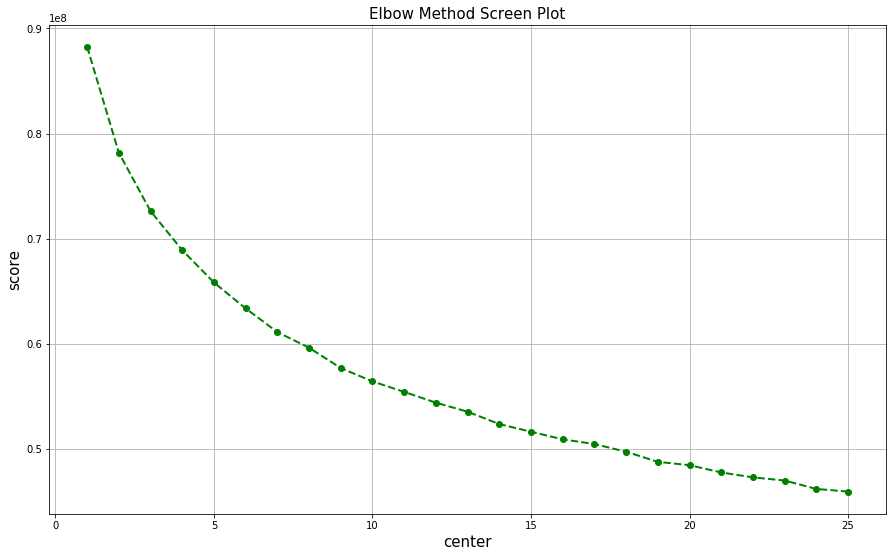

In [217]:
# Graph-9: Elbow Method Screen Plot 

# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

elbow_plot(centers, scores)

The curve doesn't have a clear "elbow" form, the inflection point can't be seen. However, we can clearly see the tendency of curve to change the direction from the vertical to the horizontal line. This change of direction takes place approximatelly on the interval between 5 to 15 clusters.

We'll choose 10 clusters for our further examination.

In [122]:
# Calc prediction labels

def get_kmeans_labels(data, n_clusters):
    
    print(f' > Calculating labels for {n_clusters} cluster(s). Please wait...')
    kmeans = KMeans(n_clusters)
    labels = kmeans.fit_predict(data)
    print(f' > Labels ready.')
    
    return labels, kmeans


In [71]:
# Finally: calculate labels
# Note that we'll use the kmeans object later when imputing the customers data. 

labels, kmeans = get_kmeans_labels(X_pca, 10)

 > Calculating labels for 10 cluster(s). Please wait...
 > Labels ready.


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

# Summary on Clustering of General Population 

Using the elbow method we have calculated the KMeans score for the interval between 1 and 25 centroids. The decrease of the score value is evident, but less evident is the elbow inflexion point. We have chosen 10 clusters which appeared to be in the middle of the "elbow interval".

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [72]:
# Load in the customer demographics data.

customers = load_customers()
customers.sample(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
27379,-1,2,1,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185435,2,4,1,1.0,4,1,5,1,2,4,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,8.0,5.0
23921,3,9,1,2.0,4,1,5,1,1,5,...,3.0,3.0,1.0,1.0,1.0,4.0,4.0,3.0,2.0,3.0
116068,3,3,2,1.0,3,1,5,1,2,5,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,2.0,6.0,2.0
96114,3,3,1,2.0,5,1,5,1,2,3,...,1.0,4.0,2.0,1.0,5.0,2.0,2.0,2.0,5.0,2.0


In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [76]:
# Clean customers data
customers = clean_data(customers)

Cleaning started. Please wait...
Input shape: (191652, 85)

 > Handling missing values...
 >> Total non-null missing values count: 860644
 > Removing columns...
 >> Outlier columns dropped.
 > Selecting, re-encoding, engineering column values...
 >> Binary encoding done.
 >> Feature CAMEO_DEU_2015 dropped.
 >> Multi-level features encoded.
 >> Mapping of the feature PRAEGENDE_JUGENDJAHRE done.
 >> Mapping of the feature CAMEO_INTL_2015 done.
 >> Mixed features encoded.
 >> Mixed features dropped.
 > Removing rows...
 >> Missing rows dropped.

Output shape: (168089, 173)
Cleaning done.


Check if both datasets have the same number of columns!

In [83]:
print('Demographic features count:', azdias.shape[1])
print('Customers features count:', customers.shape[1] - 1) # we must substract missing_count column that customers still have

Demographic features count: 173
Customers features count: 172


Ops! It looks like there is one column in the customers dataset that is missing. Which one?

In [84]:
print('Missing column in customers dataset:', set(azdias.columns) - set(customers.columns))

Missing column in customers dataset: {'GEBAEUDETYP_5.0'}


What could be the reason? Well, the only reason that I can imagine is that the original customers dataset does not contain the value 5 in the column **GEBAEUDETYP** while the demographic dataset does have it. Let's check it! 

In [87]:
azdias_check = load_azdias()
customers_check = load_customers()
print('AZDIAS:', np.sort(pd.unique(azdias_check['GEBAEUDETYP'])))
print('Customers:', np.sort(pd.unique(customers_check['GEBAEUDETYP'])))

AZDIAS: [  1.   2.   3.   4.   5.   6.   8.  nan]
Customers: [  1.   2.   3.   4.   6.   8.  nan]


In [92]:
azdias_check[azdias_check['GEBAEUDETYP'] == 5].count(axis=1)

882990    84
dtype: int64

There are only 84 values in the column GEBAEUDETYP of the original demographic dataset. As both datasets ought to have the same number of features, we will solve the anomaly buy appending the 0-value column to the customers dataset. Since its demographic superset has small number of 1-values, our maneuver cannot affect the dataset.

In [93]:
customers['GEBAEUDETYP_5.0'] = 0
print('Missing column in customers dataset:', set(azdias.columns) - set(customers.columns))

Missing column in customers dataset: set()


In [94]:
# Save checkpoint

customers.to_csv('customers_checkpoint_1a.csv', sep=';')

In [95]:
# Impute missing values 
# Note: we use the imputer object used to impute the demografic data

customers, imputer = impute_missing_values(customers, imputer)

Imputing started. Please wait...
 >> Missing values count (before): 1791378
 >> Missing values count (after): 0
Imputing done.


In [96]:
# Apply feature scaling
# Note: we use the scaler object used to scale the demografic data

X_customers, scaler = apply_feature_scaling(customers, scaler)

Feature scaling started. Please wait...
Feature scaling done.


In [97]:
print(azdias.shape)
print(customers.shape)

(833280, 173)
(168089, 173)


In [99]:
# Apply the fitted PCA and kmeans on the customer data

customers_pca = pca.transform(X_customers)
customers_labels = kmeans.predict(customers_pca)

In [105]:
# Save checkpoint

customers.to_csv('customers_checkpoint_1b.csv', sep=';')
pd.DataFrame(customers_pca).to_csv('customers_X_pca_1', sep=';')

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [195]:
# Demographic-Customers Comparison Plot function

def plot_cluster_comparison(labels, customers_labels):
    
    fig = plt.figure()
    ax=fig.add_axes([0,0,2,1], title='Demographic vs Customers distribution plot')
    ax2=fig.add_axes([0,1.2,2,1], title='Demographic count plot')
    ax3=fig.add_axes([0,2.4,2,1], title='Customer count plot')
    sns.gridcolor='white'
    sns.distplot(labels, label='demographic',ax=ax)
    sns.distplot(customers_labels, label='customers', ax=ax)
    sns.countplot(labels, label='demographic', ax=ax2)
    sns.countplot(customers_labels, label='customers', ax=ax3)
    ax.legend()
    

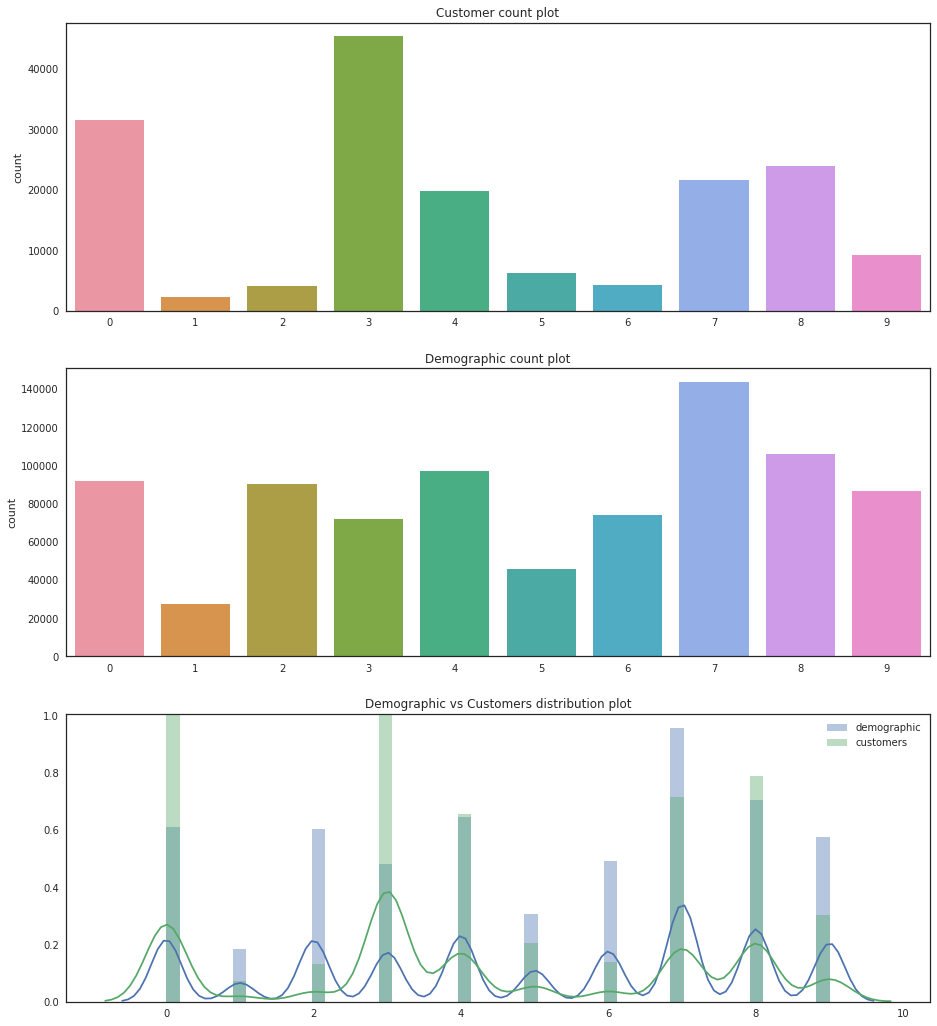

In [196]:
# do the comparison

plot_cluster_comparison(labels, customers_labels)

In [131]:
# Create dataframe with cluster comparison data

def calc_cluster_comparison(labels, customers_labels):

    demographic_clusters = pd.Series(labels)
    customers_clusters = pd.Series(customers_labels)
    demographic_count = demographic_clusters.value_counts().sort_index()
    customers_count = customers_clusters.value_counts().sort_index()
    demographic_ratio = round(demographic_clusters.value_counts().sort_index()/len(demographic_clusters) * 100, 1)
    customers_ratio = round(customers_clusters.value_counts().sort_index()/len(customers_clusters) * 100, 1)
    diff_ratio = customers_ratio - demographic_ratio

    cluster_comparison = pd.DataFrame({
        'demographic_count': demographic_count,
        'customers_count': customers_count,    
        'demographic_ratio': demographic_ratio,
        'customers_ratio': customers_ratio,
        'diff_ratio': diff_ratio
    })
    
    return cluster_comparison


In [171]:
# do compare

calc_cluster_comparison(labels, customers_labels).sort_values(by='diff_ratio', ascending=False)

,demographic_count,customers_count,demographic_ratio,customers_ratio,diff_ratio
3,71957,45330,8.6,27.0,18.4
0,91550,31550,11.0,18.8,7.8
8,105649,23815,12.7,14.2,1.5
4,96926,19838,11.6,11.8,0.2
5,45751,6236,5.5,3.7,-1.8
1,27466,2224,3.3,1.3,-2.0
7,143545,21650,17.2,12.9,-4.3
9,86427,9209,10.4,5.5,-4.9
6,73657,4208,8.8,2.5,-6.3
2,90352,4029,10.8,2.4,-8.4


The comparison based on ratio reveals that the overrepresented clusters are 3 and 0 and the underrepresented clusters are 2 and 6.

In [221]:
# Show principal components of the given cluster

def show_principal_components_by_cluster(cluster, n=5):
    
    pc = kmeans.cluster_centers_[cluster]
    pc = pd.Series(pc)
    pc.index = pc.index +1
    
    print(pc.sort_values(ascending=False).head(n))


In [228]:
# Transform centroids back to the original data space
# (We'll use this function to get to the original values to better interpret the results.)

def inverse_clusters_to_dataspace(datasource, kmeans, scaler, pca):
    inversed = pd.DataFrame(scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_)), 
                            columns=azdias.columns).transpose()

    return inversed


In [234]:
# Get inversed dataframe

inversed = inverse_clusters_to_dataspace(azdias, kmeans, scaler, pca)
inversed.head(10)

,0,1,2,3,4,5,6,7,8,9
ALTERSKATEGORIE_GROB,3.663886,2.546843,1.925572,2.600051,3.729610,2.775786,2.154700,3.742229,3.649292,2.093152
ANREDE_KZ,1.334784,1.561442,1.853815,1.421701,1.499922,1.358835,0.824706,1.337008,1.298878,1.320917
FINANZ_MINIMALIST,5.124909,3.468366,2.430633,3.850199,3.935435,4.231396,3.121346,3.792031,5.124866,3.800408
FINANZ_SPARER,0.961429,2.818935,3.601136,3.225799,1.158419,2.465964,3.465154,1.246455,1.031529,3.213581
FINANZ_VORSORGER,4.822219,3.691581,3.209480,3.728719,4.856176,3.864881,3.187956,4.832509,4.765766,3.182176
FINANZ_ANLEGER,1.066665,3.506056,3.996997,4.685140,1.673928,3.058247,3.016346,1.133764,1.798899,3.884879
FINANZ_UNAUFFAELLIGER,1.858126,3.246816,3.854030,5.041732,1.563572,3.158776,3.660296,1.327670,1.578565,4.035912
FINANZ_HAUSBAUER,2.065863,2.693803,3.724902,2.674354,3.407883,1.892341,3.130606,3.546660,2.008434,2.105485
GREEN_AVANTGARDE,1.302653,0.350989,0.188623,0.152995,0.302714,0.554403,0.278632,0.184992,0.135047,0.471631
HEALTH_TYP,1.844877,2.021513,1.977564,2.001112,1.914401,2.023995,2.131948,1.965263,1.965775,2.026093


# OVERREPRESENTED

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

In [257]:
# First let's see which principal components play the most important role in the overrepresented cluster 3.

show_principal_components_by_cluster(3)

6     2.491715
4     1.591557
8     0.822398
1     0.569881
10    0.534398
dtype: float64


So, we'll focus on the components 6 and 4.

In [222]:
# Let's check the features, ordered by weight, of the component 6.

show_pca_weights(pca, azdias, 6, 10)

Principal component #6 (Explained Variance=0.0246)
Positive weights ordered list:
----------------------------------------------------
ANZ_PERSONEN                0.1848
LP_FAMILIE_GROB_5.0         0.1744
LP_STATUS_FEIN_5.0          0.1559
KKK                         0.1486
LP_FAMILIE_FEIN_10.0        0.1447
LP_LEBENSPHASE_GROB_10.0    0.1348
ZABEOTYP_3                  0.1329
FINANZTYP_4                 0.1329
SEMIO_FAM                   0.1298
GFK_URLAUBERTYP_5.0         0.1234
Name: Principal Component 6, dtype: float64
----------------------------------------------------
Negative weights ordered list:
----------------------------------------------------
LP_FAMILIE_GROB_1.0              -0.2704
LP_FAMILIE_FEIN_1.0              -0.2704
GREEN_AVANTGARDE                 -0.2143
LP_STATUS_FEIN_10.0              -0.1893
LP_STATUS_GROB_5.0               -0.1893
PRAEGENDE_JUGENDJAHRE_movement   -0.1882
LP_LEBENSPHASE_GROB_1.0          -0.1719
LP_LEBENSPHASE_GROB_3.0          -0.1607
ANREDE

In [283]:
# Let's check also the overrepresented cluster 0...

show_principal_components_by_cluster(0)

4     2.864371
2     1.699436
3     1.104405
13    0.490771
10    0.447046
dtype: float64


In [285]:
# ... Aand its corresponding features.

show_pca_weights(pca, azdias, 4, 5)

Principal component #4 (Explained Variance=0.0326)
Positive weights ordered list:
----------------------------------------------------
PRAEGENDE_JUGENDJAHRE_movement    0.2548
GREEN_AVANTGARDE                  0.2375
LP_STATUS_FEIN_10.0               0.2015
LP_STATUS_GROB_5.0                0.2015
ORTSGR_KLS9                       0.1960
Name: Principal Component 4, dtype: float64
----------------------------------------------------
Negative weights ordered list:
----------------------------------------------------
LP_FAMILIE_GROB_1.0   -0.2228
LP_FAMILIE_FEIN_1.0   -0.2228
WOHNLAGE_7.0          -0.1840
HH_EINKOMMEN_SCORE    -0.1705
LP_STATUS_GROB_4.0    -0.1594
Name: Principal Component 4, dtype: float64
----------------------------------------------------


In [223]:
# Let's also check the second component's features.

show_pca_weights(pca, azdias, 4, 5)

Principal component #4 (Explained Variance=0.0326)
Positive weights ordered list:
----------------------------------------------------
PRAEGENDE_JUGENDJAHRE_movement    0.2548
GREEN_AVANTGARDE                  0.2375
LP_STATUS_FEIN_10.0               0.2015
LP_STATUS_GROB_5.0                0.2015
ORTSGR_KLS9                       0.1960
Name: Principal Component 4, dtype: float64
----------------------------------------------------
Negative weights ordered list:
----------------------------------------------------
LP_FAMILIE_GROB_1.0   -0.2228
LP_FAMILIE_FEIN_1.0   -0.2228
WOHNLAGE_7.0          -0.1840
HH_EINKOMMEN_SCORE    -0.1705
LP_STATUS_GROB_4.0    -0.1594
Name: Principal Component 4, dtype: float64
----------------------------------------------------


# UNDERREPRESENTED

In [258]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

In [259]:
# Let's see which principal components play the most important role in the underrepresented cluster 2.

show_principal_components_by_cluster(2)

1     4.702062
5     1.170296
15    0.443220
7     0.346157
35    0.167562
dtype: float64


We'll focus on the first component.

In [260]:
# Check the features of the component 1.

show_pca_weights(pca, azdias, 1, 10)

Principal component #1 (Explained Variance=0.0933)
Positive weights ordered list:
----------------------------------------------------
LP_STATUS_GROB_1.0        0.1838
PLZ8_ANTG3                0.1836
PLZ8_ANTG4                0.1776
CAMEO_INTL_2015_wealth    0.1760
ORTSGR_KLS9               0.1587
EWDICHTE                  0.1566
HH_EINKOMMEN_SCORE        0.1559
FINANZ_HAUSBAUER          0.1466
PLZ8_ANTG2                0.1265
LP_STATUS_FEIN_1.0        0.1254
Name: Principal Component 1, dtype: float64
----------------------------------------------------
Negative weights ordered list:
----------------------------------------------------
MOBI_REGIO           -0.2007
KBA05_ANTG1          -0.1876
PLZ8_ANTG1           -0.1834
FINANZ_MINIMALIST    -0.1828
KBA05_GBZ            -0.1789
PLZ8_BAUMAX_1.0      -0.1687
KONSUMNAEHE          -0.1360
PLZ8_GBZ             -0.1351
INNENSTADT           -0.1296
LP_STATUS_GROB_4.0   -0.1131
Name: Principal Component 1, dtype: float64
--------------------

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

# Summary on Comparison between Customer Data and Demographics Data

The interpretation of the comparison was a bit difficult due to the lacking of clear feature contrast between the customers and non-customers that I couldn't find (or was not able to see).

It seems that the customers are mostly of higher age, they live in a multiperson household in a region with average to high purchasing power. The question of income is where the data most confuses me. I would prefer to say that the costumers belong to the specific and well-defined earning group (like high income earners) but the information that I was able to extract is telling me that their earnings occupy a wider interval between low-average to high income. Their are prudent in financial decisions and they have strong affinity to environmental issues.

On the other side, the non-customers have lower income, they live in small cities in buildings with many apartments and they have low financial interest. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.